In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Documents/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2025/PEDIATRIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 10 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=191.2, y1=127.4
Page 1, Q1, A: Yellow pixels: 1448
Page 1, Q1, A: Total non-white pixels: 2088
Page 1, Q1, A: Yellow percentage: 69.3%


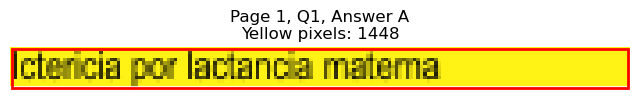

Page 1, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=154.6, y1=140.0
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 451
Page 1, Q1, B: Yellow percentage: 0.0%


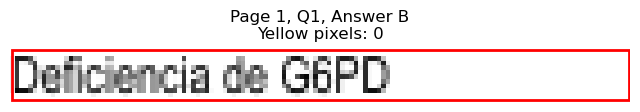

Page 1, Q1 - C: Detected box: x0=327.5, y0=116.4, x1=416.8, y1=127.4
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 493
Page 1, Q1, C: Yellow percentage: 0.0%


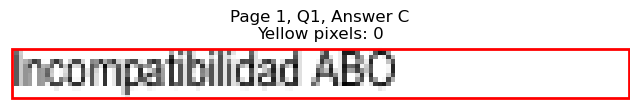

Page 1, Q1 - D: Detected box: x0=327.5, y0=129.0, x1=394.2, y1=140.0
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 346
Page 1, Q1, D: Yellow percentage: 0.0%


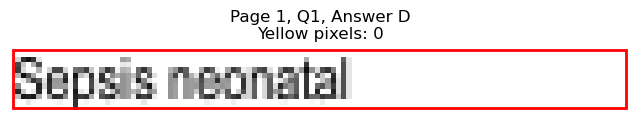


Page 1, Q1 - Selected Answer: A (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=219.7, y1=190.5
Page 1, Q2, A: Yellow pixels: 202
Page 1, Q2, A: Total non-white pixels: 914
Page 1, Q2, A: Yellow percentage: 22.1%


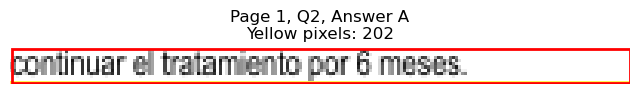

Page 1, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=318.1, y1=203.1
Page 1, Q2, B: Yellow pixels: 2393
Page 1, Q2, B: Total non-white pixels: 3318
Page 1, Q2, B: Yellow percentage: 72.1%


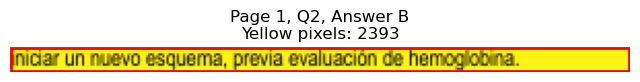

Page 1, Q2 - C: Detected box: x0=68.8, y0=204.7, x1=245.8, y1=215.7
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 848
Page 1, Q2, C: Yellow percentage: 0.0%


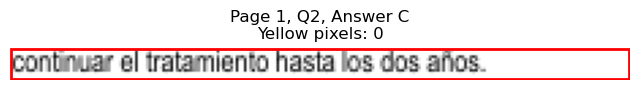

Page 1, Q2 - D: Detected box: x0=68.8, y0=217.4, x1=361.6, y1=228.4
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 1472
Page 1, Q2, D: Yellow percentage: 0.0%


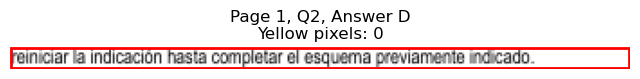


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=280.5, x1=180.6, y1=291.6
Page 1, Q3, A: Yellow pixels: 1352
Page 1, Q3, A: Total non-white pixels: 1956
Page 1, Q3, A: Yellow percentage: 69.1%


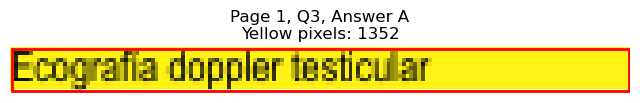

Page 1, Q3 - B: Detected box: x0=68.3, y0=293.1, x1=148.1, y1=304.2
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 424
Page 1, Q3, B: Yellow percentage: 0.0%


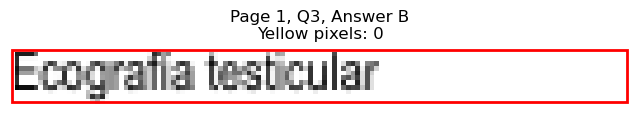

Page 1, Q3 - C: Detected box: x0=327.5, y0=280.5, x1=421.8, y1=291.6
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 487
Page 1, Q3, C: Yellow percentage: 0.0%


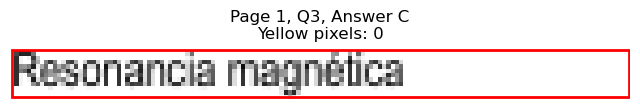

Page 1, Q3 - D: Detected box: x0=327.5, y0=293.1, x1=423.7, y1=304.2
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 492
Page 1, Q3, D: Yellow percentage: 0.0%


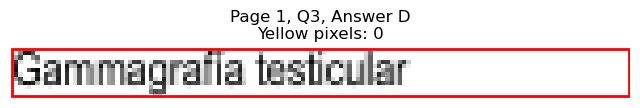


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=343.6, x1=116.9, y1=354.7
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 245
Page 1, Q4, A: Yellow percentage: 0.0%


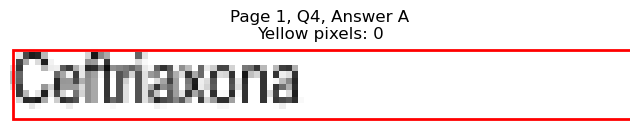

Page 1, Q4 - B: Detected box: x0=68.3, y0=356.2, x1=116.4, y1=367.3
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 250
Page 1, Q4, B: Yellow percentage: 0.0%


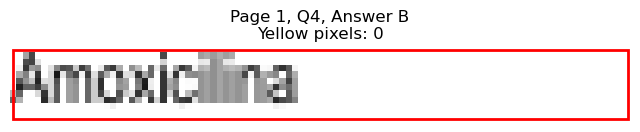

Page 1, Q4 - C: Detected box: x0=327.5, y0=343.6, x1=385.1, y1=354.7
Page 1, Q4, C: Yellow pixels: 109
Page 1, Q4, C: Total non-white pixels: 416
Page 1, Q4, C: Yellow percentage: 26.2%


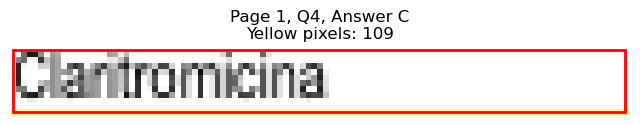

Page 1, Q4 - D: Detected box: x0=327.5, y0=356.2, x1=447.4, y1=367.3
Page 1, Q4, D: Yellow pixels: 1422
Page 1, Q4, D: Total non-white pixels: 2052
Page 1, Q4, D: Yellow percentage: 69.3%


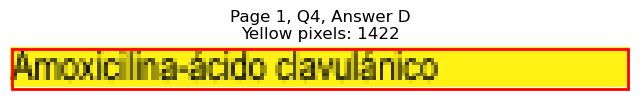


Page 1, Q4 - Selected Answer: D (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=406.6, x1=104.4, y1=417.7
Page 1, Q5, A: Yellow pixels: 894
Page 1, Q5, A: Total non-white pixels: 1044
Page 1, Q5, A: Yellow percentage: 85.6%


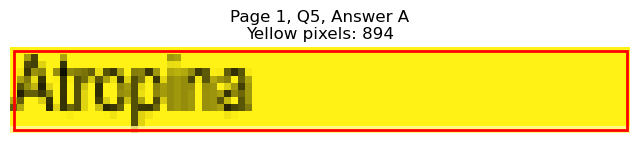

Page 1, Q5 - B: Detected box: x0=68.3, y0=419.4, x1=114.4, y1=430.4
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 231
Page 1, Q5, B: Yellow percentage: 0.0%


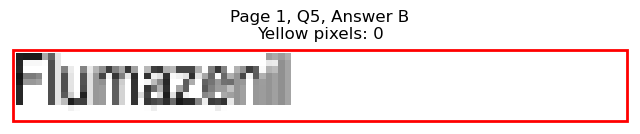

Page 1, Q5 - C: Detected box: x0=327.5, y0=406.6, x1=368.2, y1=417.7
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 207
Page 1, Q5, C: Yellow percentage: 0.0%


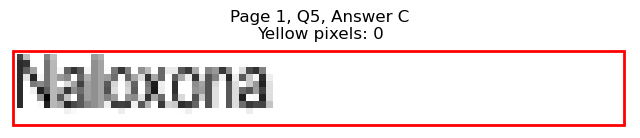

Page 1, Q5 - D: Detected box: x0=327.5, y0=419.4, x1=395.6, y1=430.4
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 341
Page 1, Q5, D: Yellow percentage: 0.0%


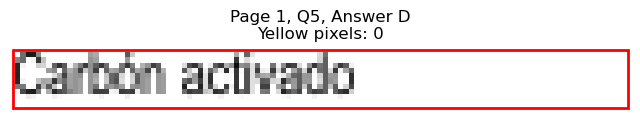


Page 1, Q5 - Selected Answer: A (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=469.8, x1=192.2, y1=480.8
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 642
Page 1, Q6, A: Yellow percentage: 0.0%


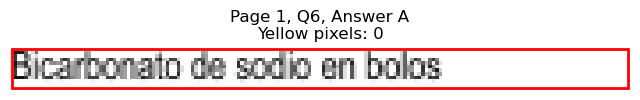

Page 1, Q6 - B: Detected box: x0=68.3, y0=482.5, x1=116.9, y1=493.5
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 204
Page 1, Q6, B: Yellow percentage: 0.0%


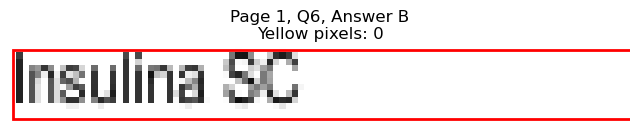

Page 1, Q6 - C: Detected box: x0=327.5, y0=469.8, x1=389.2, y1=480.8
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 420
Page 1, Q6, C: Yellow percentage: 0.0%


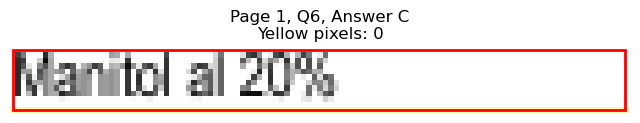

Page 1, Q6 - D: Detected box: x0=327.5, y0=482.5, x1=407.3, y1=493.5
Page 1, Q6, D: Yellow pixels: 1161
Page 1, Q6, D: Total non-white pixels: 1572
Page 1, Q6, D: Yellow percentage: 73.9%


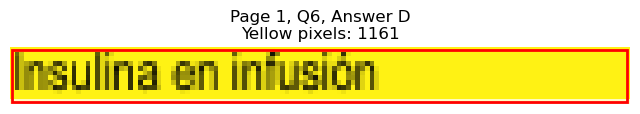


Page 1, Q6 - Selected Answer: D (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=545.5, x1=173.6, y1=556.5
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 558
Page 1, Q7, A: Yellow percentage: 0.0%


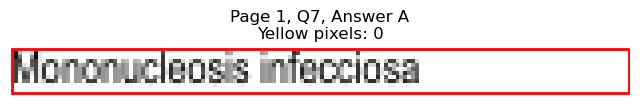

Page 1, Q7 - B: Detected box: x0=68.3, y0=558.2, x1=166.6, y1=569.2
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 524
Page 1, Q7, B: Yellow percentage: 0.0%


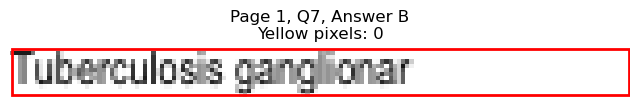

Page 1, Q7 - C: Detected box: x0=327.5, y0=545.5, x1=462.5, y1=556.5
Page 1, Q7, C: Yellow pixels: 1565
Page 1, Q7, C: Total non-white pixels: 2232
Page 1, Q7, C: Yellow percentage: 70.1%


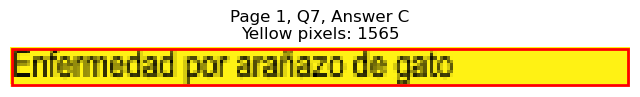

Page 1, Q7 - D: Detected box: x0=327.5, y0=558.2, x1=390.7, y1=569.2
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 348
Page 1, Q7, D: Yellow percentage: 0.0%


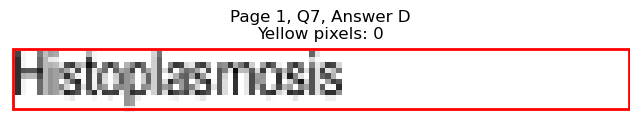


Page 1, Q7 - Selected Answer: C (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=608.6, x1=127.4, y1=619.6
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 313
Page 1, Q8, A: Yellow percentage: 0.0%


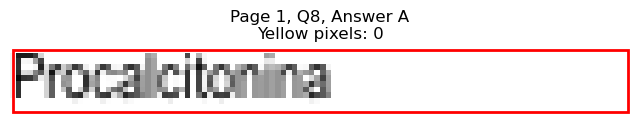

Page 1, Q8 - B: Detected box: x0=68.3, y0=621.3, x1=89.9, y1=632.4
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 106
Page 1, Q8, B: Yellow percentage: 0.0%


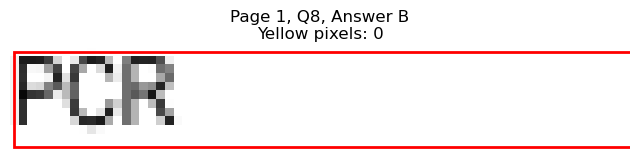

Page 1, Q8 - C: Detected box: x0=327.5, y0=608.6, x1=359.6, y1=619.6
Page 1, Q8, C: Yellow pixels: 880
Page 1, Q8, C: Total non-white pixels: 996
Page 1, Q8, C: Yellow percentage: 88.4%


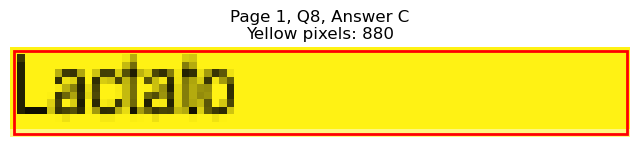

Page 1, Q8 - D: Detected box: x0=327.5, y0=621.3, x1=368.2, y1=632.4
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 187
Page 1, Q8, D: Yellow percentage: 0.0%


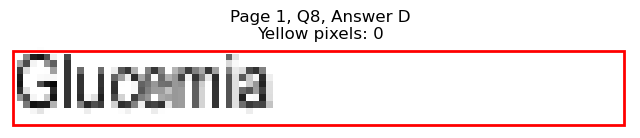


Page 1, Q8 - Selected Answer: C (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=671.7, x1=113.9, y1=682.8
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 235
Page 1, Q9, A: Yellow percentage: 0.0%


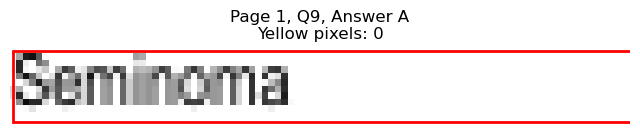

Page 1, Q9 - B: Detected box: x0=68.3, y0=684.3, x1=164.5, y1=695.4
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 481
Page 1, Q9, B: Yellow percentage: 0.0%


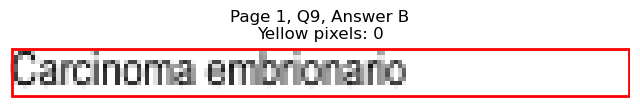

Page 1, Q9 - C: Detected box: x0=327.5, y0=671.7, x1=422.8, y1=682.8
Page 1, Q9, C: Yellow pixels: 1402
Page 1, Q9, C: Total non-white pixels: 1752
Page 1, Q9, C: Yellow percentage: 80.0%


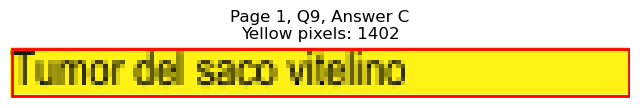

Page 1, Q9 - D: Detected box: x0=327.5, y0=684.3, x1=393.1, y1=695.4
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 333
Page 1, Q9, D: Yellow percentage: 0.0%


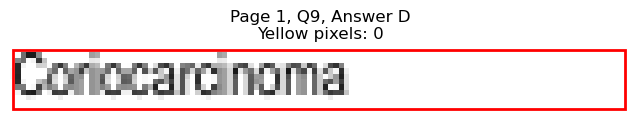


Page 1, Q9 - Selected Answer: C (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=68.3, y0=747.4, x1=213.2, y1=758.5
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 742
Page 1, Q10, A: Yellow percentage: 0.0%


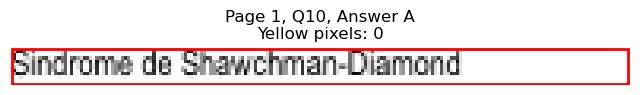

Page 1, Q10 - B: Detected box: x0=68.3, y0=760.2, x1=164.0, y1=771.2
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 530
Page 1, Q10, B: Yellow percentage: 0.0%


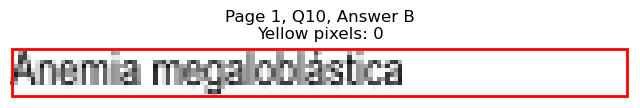

Page 1, Q10 - C: Detected box: x0=327.5, y0=747.4, x1=407.8, y1=758.5
Page 1, Q10, C: Yellow pixels: 1170
Page 1, Q10, C: Total non-white pixels: 1572
Page 1, Q10, C: Yellow percentage: 74.4%


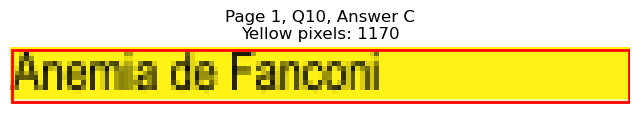

Page 1, Q10 - D: Detected box: x0=327.5, y0=760.2, x1=413.3, y1=771.2
Page 1, Q10, D: Yellow pixels: 0
Page 1, Q10, D: Total non-white pixels: 438
Page 1, Q10, D: Yellow percentage: 0.0%


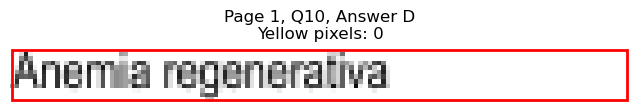


Page 1, Q10 - Selected Answer: C (based on yellow pixel count)





Page 2: Found 8 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=329.0, y1=114.8
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 1242
Page 2, Q1, A: Yellow percentage: 0.0%


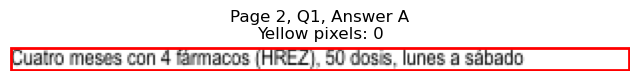

Page 2, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=360.1, y1=127.4
Page 2, Q1, B: Yellow pixels: 343
Page 2, Q1, B: Total non-white pixels: 1788
Page 2, Q1, B: Yellow percentage: 19.2%


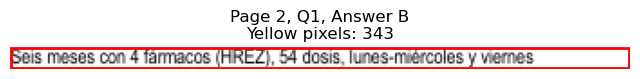

Page 2, Q1 - C: Detected box: x0=68.8, y0=129.0, x1=318.5, y1=140.0
Page 2, Q1, C: Yellow pixels: 2660
Page 2, Q1, C: Total non-white pixels: 3612
Page 2, Q1, C: Yellow percentage: 73.6%


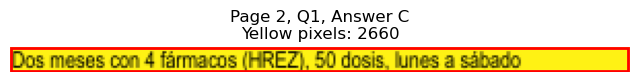

Page 2, Q1 - D: Detected box: x0=68.8, y0=141.7, x1=322.6, y1=152.7
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 1256
Page 2, Q1, D: Yellow percentage: 0.0%


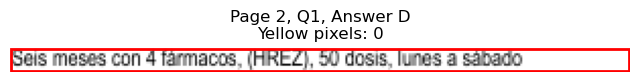


Page 2, Q1 - Selected Answer: C (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=68.3, y0=217.4, x1=360.1, y1=228.4
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 1552
Page 2, Q2, A: Yellow percentage: 0.0%


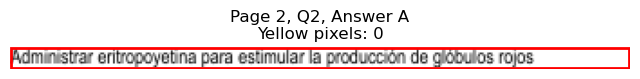

Page 2, Q2 - B: Detected box: x0=68.3, y0=230.0, x1=415.3, y1=241.0
Page 2, Q2, B: Yellow pixels: 398
Page 2, Q2, B: Total non-white pixels: 2477
Page 2, Q2, B: Yellow percentage: 16.1%


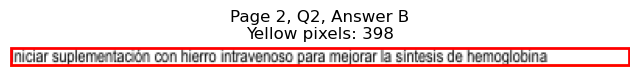

Page 2, Q2 - C: Detected box: x0=68.8, y0=242.6, x1=349.7, y1=253.6
Page 2, Q2, C: Yellow pixels: 2604
Page 2, Q2, C: Total non-white pixels: 3984
Page 2, Q2, C: Yellow percentage: 65.4%


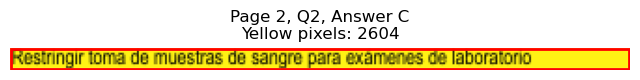

Page 2, Q2 - D: Detected box: x0=68.8, y0=255.2, x1=235.7, y1=266.2
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 820
Page 2, Q2, D: Yellow percentage: 0.0%


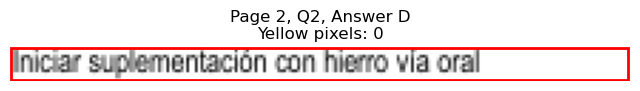


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=330.9, x1=359.8, y1=342.0
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 1524
Page 2, Q3, A: Yellow percentage: 0.0%


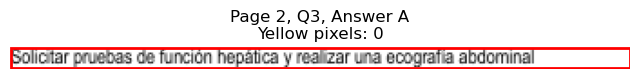

Page 2, Q3 - B: Detected box: x0=68.3, y0=343.6, x1=406.8, y1=354.7
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 1720
Page 2, Q3, B: Yellow percentage: 0.0%


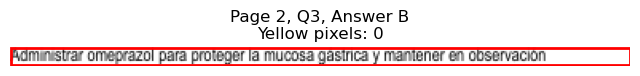

Page 2, Q3 - C: Detected box: x0=68.8, y0=356.2, x1=323.5, y1=367.3
Page 2, Q3, C: Yellow pixels: 306
Page 2, Q3, C: Total non-white pixels: 1620
Page 2, Q3, C: Yellow percentage: 18.9%


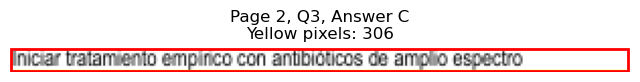

Page 2, Q3 - D: Detected box: x0=68.8, y0=368.8, x1=384.1, y1=379.9
Page 2, Q3, D: Yellow pixels: 3200
Page 2, Q3, D: Total non-white pixels: 4404
Page 2, Q3, D: Yellow percentage: 72.7%


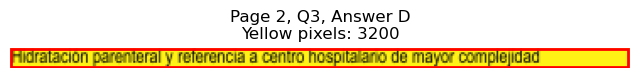


Page 2, Q3 - Selected Answer: D (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=406.6, x1=122.5, y1=417.7
Page 2, Q4, A: Yellow pixels: 1026
Page 2, Q4, A: Total non-white pixels: 1260
Page 2, Q4, A: Yellow percentage: 81.4%


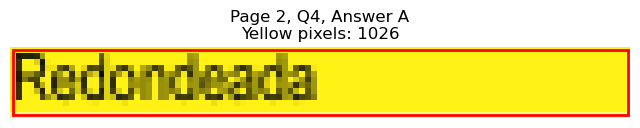

Page 2, Q4 - B: Detected box: x0=68.3, y0=419.4, x1=100.9, y1=430.4
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 135
Page 2, Q4, B: Yellow percentage: 0.0%


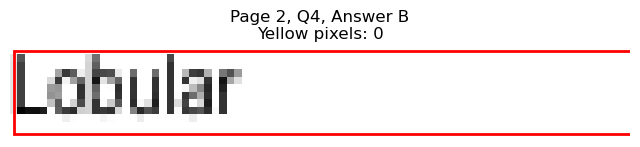

Page 2, Q4 - C: Detected box: x0=327.5, y0=406.6, x1=355.6, y1=417.7
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 143
Page 2, Q4, C: Yellow percentage: 0.0%


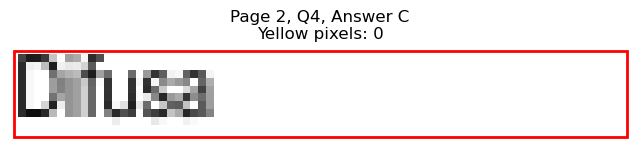

Page 2, Q4 - D: Detected box: x0=327.5, y0=419.4, x1=368.2, y1=430.4
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 209
Page 2, Q4, D: Yellow percentage: 0.0%


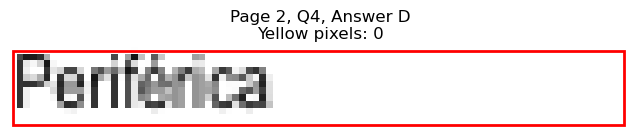


Page 2, Q4 - Selected Answer: A (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=495.1, x1=173.6, y1=506.1
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 540
Page 2, Q5, A: Yellow percentage: 0.0%


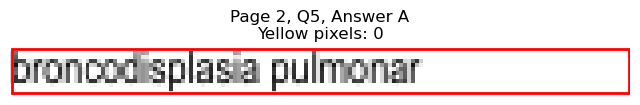

Page 2, Q5 - B: Detected box: x0=68.3, y0=507.7, x1=133.0, y1=518.7
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 329
Page 2, Q5, B: Yellow percentage: 0.0%


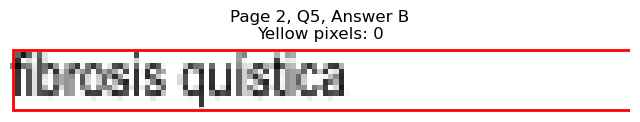

Page 2, Q5 - C: Detected box: x0=327.5, y0=495.1, x1=405.7, y1=506.1
Page 2, Q5, C: Yellow pixels: 129
Page 2, Q5, C: Total non-white pixels: 659
Page 2, Q5, C: Yellow percentage: 19.6%


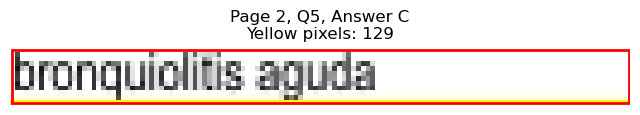

Page 2, Q5 - D: Detected box: x0=327.5, y0=507.7, x1=422.8, y1=518.7
Page 2, Q5, D: Yellow pixels: 1397
Page 2, Q5, D: Total non-white pixels: 1752
Page 2, Q5, D: Yellow percentage: 79.7%


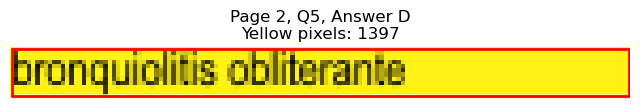


Page 2, Q5 - Selected Answer: D (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=583.4, x1=147.0, y1=594.4
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 406
Page 2, Q6, A: Yellow percentage: 0.0%


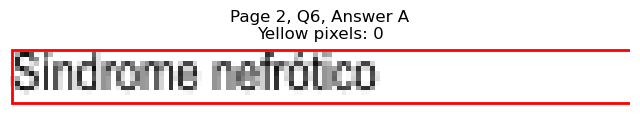

Page 2, Q6 - B: Detected box: x0=68.3, y0=596.0, x1=144.5, y1=607.0
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 408
Page 2, Q6, B: Yellow percentage: 0.0%


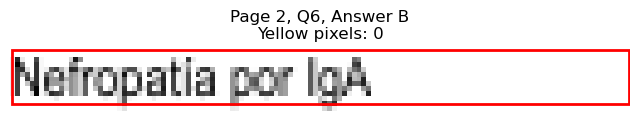

Page 2, Q6 - C: Detected box: x0=327.5, y0=583.4, x1=358.2, y1=594.4
Page 2, Q6, C: Yellow pixels: 767
Page 2, Q6, C: Total non-white pixels: 984
Page 2, Q6, C: Yellow percentage: 77.9%


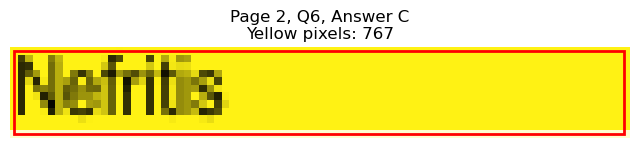

Page 2, Q6 - D: Detected box: x0=327.5, y0=596.0, x1=407.8, y1=607.0
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 408
Page 2, Q6, D: Yellow percentage: 0.0%


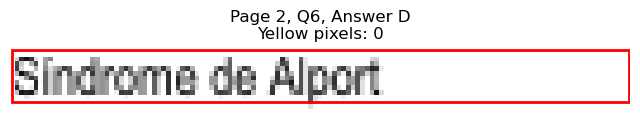


Page 2, Q6 - Selected Answer: C (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=659.1, x1=154.0, y1=670.2
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 435
Page 2, Q7, A: Yellow percentage: 0.0%


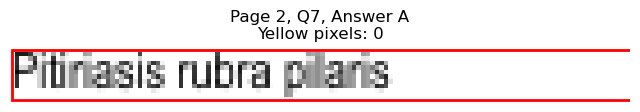

Page 2, Q7 - B: Detected box: x0=68.3, y0=671.7, x1=104.4, y1=682.8
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 191
Page 2, Q7, B: Yellow percentage: 0.0%


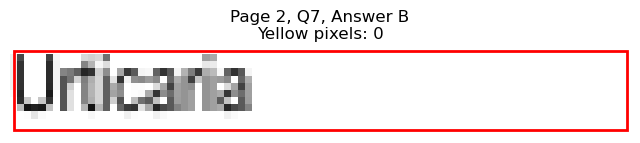

Page 2, Q7 - C: Detected box: x0=327.5, y0=659.1, x1=441.4, y1=670.2
Page 2, Q7, C: Yellow pixels: 1406
Page 2, Q7, C: Total non-white pixels: 1815
Page 2, Q7, C: Yellow percentage: 77.5%


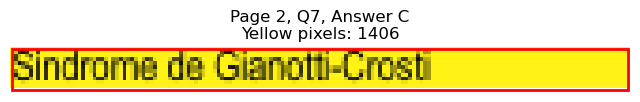

Page 2, Q7 - D: Detected box: x0=327.5, y0=671.7, x1=373.7, y1=682.8
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 235
Page 2, Q7, D: Yellow percentage: 0.0%


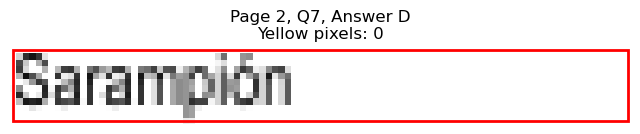


Page 2, Q7 - Selected Answer: C (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=722.2, x1=195.2, y1=733.3
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 624
Page 2, Q8, A: Yellow percentage: 0.0%


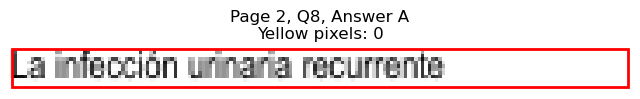

Page 2, Q8 - B: Detected box: x0=68.3, y0=734.8, x1=192.7, y1=745.9
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 637
Page 2, Q8, B: Yellow percentage: 0.0%


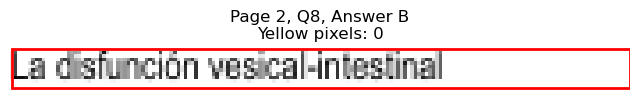

Page 2, Q8 - C: Detected box: x0=327.5, y0=722.2, x1=423.7, y1=733.3
Page 2, Q8, C: Yellow pixels: 1247
Page 2, Q8, C: Total non-white pixels: 1764
Page 2, Q8, C: Yellow percentage: 70.7%


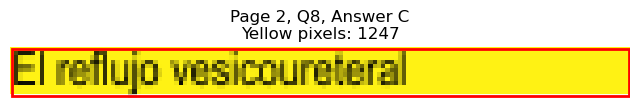

Page 2, Q8 - D: Detected box: x0=327.5, y0=734.8, x1=418.3, y1=745.9
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 464
Page 2, Q8, D: Yellow percentage: 0.0%


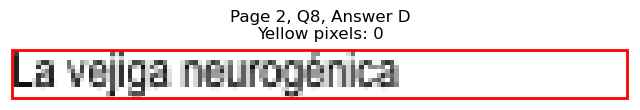


Page 2, Q8 - Selected Answer: C (based on yellow pixel count)





Page 3: Found 9 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=113.9, y1=114.8
Page 3, Q1, A: Yellow pixels: 96
Page 3, Q1, A: Total non-white pixels: 324
Page 3, Q1, A: Yellow percentage: 29.6%


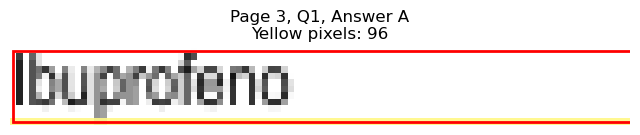

Page 3, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=131.5, y1=127.4
Page 3, Q1, B: Yellow pixels: 997
Page 3, Q1, B: Total non-white pixels: 1368
Page 3, Q1, B: Yellow percentage: 72.9%


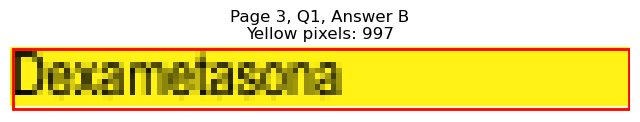

Page 3, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=374.2, y1=114.8
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 238
Page 3, Q1, C: Yellow percentage: 0.0%


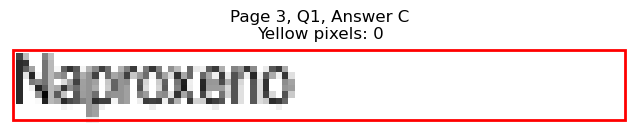

Page 3, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=416.8, y1=127.4
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 462
Page 3, Q1, D: Yellow percentage: 0.0%


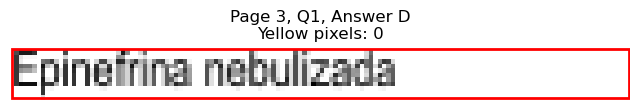


Page 3, Q1 - Selected Answer: B (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=166.9, x1=174.1, y1=177.9
Page 3, Q2, A: Yellow pixels: 1456
Page 3, Q2, A: Total non-white pixels: 1884
Page 3, Q2, A: Yellow percentage: 77.3%


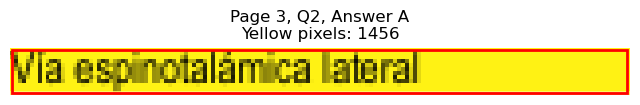

Page 3, Q2 - B: Detected box: x0=68.3, y0=179.5, x1=153.5, y1=190.5
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 436
Page 3, Q2, B: Yellow percentage: 0.0%


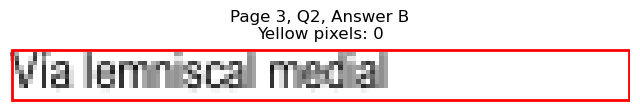

Page 3, Q2 - C: Detected box: x0=327.5, y0=166.9, x1=428.8, y1=177.9
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 522
Page 3, Q2, C: Yellow percentage: 0.0%


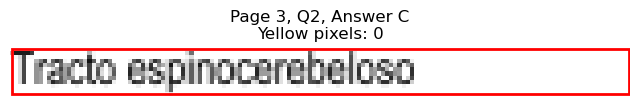

Page 3, Q2 - D: Detected box: x0=327.5, y0=179.5, x1=440.3, y1=190.5
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 581
Page 3, Q2, D: Yellow percentage: 0.0%


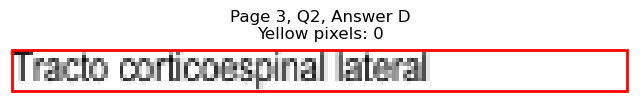


Page 3, Q2 - Selected Answer: A (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=230.0, x1=216.7, y1=241.0
Page 3, Q3, A: Yellow pixels: 199
Page 3, Q3, A: Total non-white pixels: 1096
Page 3, Q3, A: Yellow percentage: 18.2%


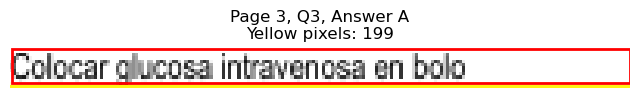

Page 3, Q3 - B: Detected box: x0=68.3, y0=242.6, x1=311.0, y1=253.6
Page 3, Q3, B: Yellow pixels: 2328
Page 3, Q3, B: Total non-white pixels: 3528
Page 3, Q3, B: Yellow percentage: 66.0%


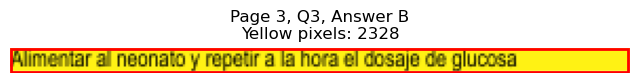

Page 3, Q3 - C: Detected box: x0=68.8, y0=255.2, x1=203.2, y1=266.2
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 645
Page 3, Q3, C: Yellow percentage: 0.0%


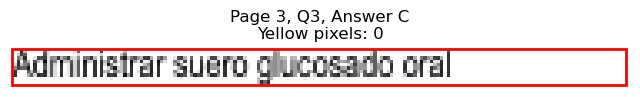

Page 3, Q3 - D: Detected box: x0=68.8, y0=267.8, x1=228.2, y1=278.8
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 794
Page 3, Q3, D: Yellow percentage: 0.0%


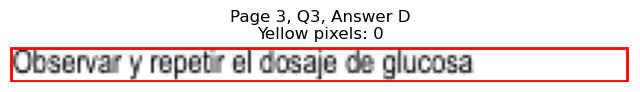


Page 3, Q3 - Selected Answer: B (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=343.6, x1=168.1, y1=354.7
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 539
Page 3, Q4, A: Yellow percentage: 0.0%


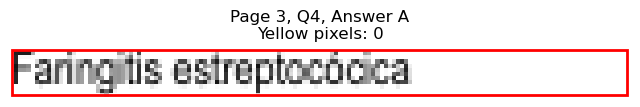

Page 3, Q4 - B: Detected box: x0=68.3, y0=356.2, x1=168.1, y1=367.3
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 485
Page 3, Q4, B: Yellow percentage: 0.0%


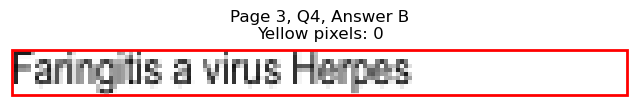

Page 3, Q4 - C: Detected box: x0=327.5, y0=343.6, x1=376.7, y1=354.7
Page 3, Q4, C: Yellow pixels: 984
Page 3, Q4, C: Total non-white pixels: 1200
Page 3, Q4, C: Yellow percentage: 82.0%


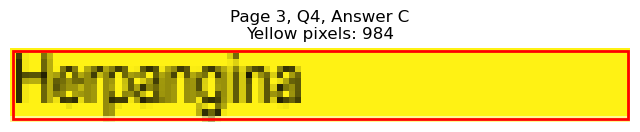

Page 3, Q4 - D: Detected box: x0=327.5, y0=356.2, x1=432.8, y1=367.3
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 549
Page 3, Q4, D: Yellow percentage: 0.0%


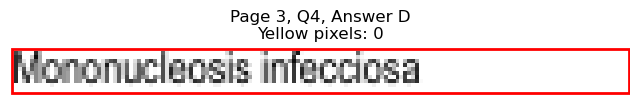


Page 3, Q4 - Selected Answer: C (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=394.0, x1=310.0, y1=405.1
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 1266
Page 3, Q5, A: Yellow percentage: 0.0%


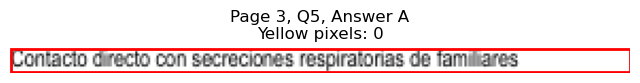

Page 3, Q5 - B: Detected box: x0=68.3, y0=406.6, x1=402.1, y1=417.7
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 1692
Page 3, Q5, B: Yellow percentage: 0.0%


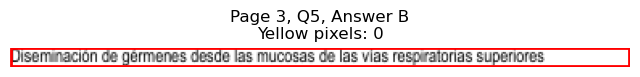

Page 3, Q5 - C: Detected box: x0=68.8, y0=419.4, x1=234.8, y1=430.4
Page 3, Q5, C: Yellow pixels: 217
Page 3, Q5, C: Total non-white pixels: 1035
Page 3, Q5, C: Yellow percentage: 21.0%


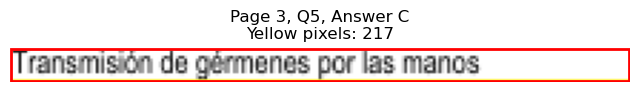

Page 3, Q5 - D: Detected box: x0=68.8, y0=432.0, x1=124.0, y1=443.0
Page 3, Q5, D: Yellow pixels: 1069
Page 3, Q5, D: Total non-white pixels: 1272
Page 3, Q5, D: Yellow percentage: 84.0%


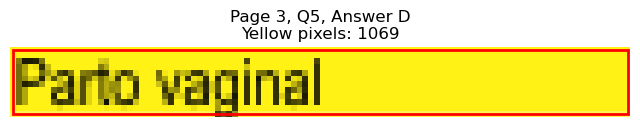


Page 3, Q5 - Selected Answer: D (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=56.6, y0=469.8, x1=65.2, y1=480.8
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 44
Page 3, Q6, A: Yellow percentage: 0.0%


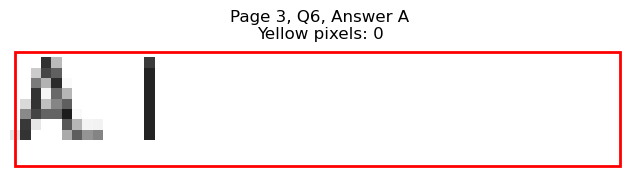

Page 3, Q6 - B: Detected box: x0=56.6, y0=482.5, x1=65.2, y1=493.5
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 66
Page 3, Q6, B: Yellow percentage: 0.0%


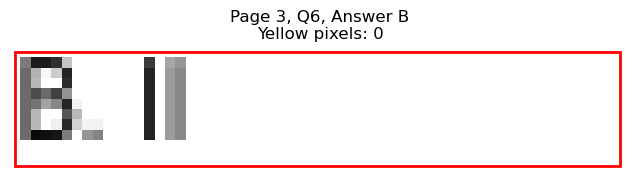

Page 3, Q6 - C: Detected box: x0=327.5, y0=469.8, x1=337.6, y1=480.8
Page 3, Q6, C: Yellow pixels: 692
Page 3, Q6, C: Total non-white pixels: 732
Page 3, Q6, C: Yellow percentage: 94.5%


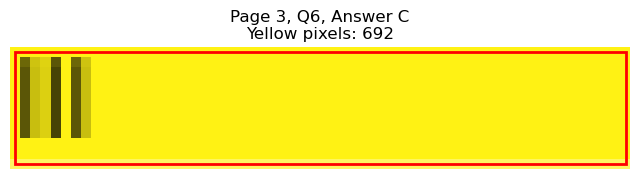

Page 3, Q6 - D: Detected box: x0=315.4, y0=482.5, x1=324.4, y1=493.5
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 85
Page 3, Q6, D: Yellow percentage: 0.0%


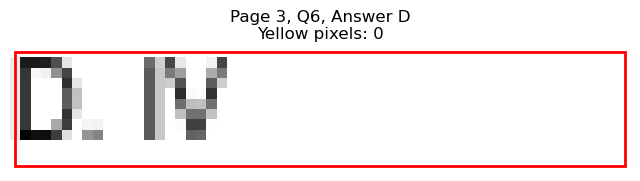


Page 3, Q6 - Selected Answer: C (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=558.2, x1=115.0, y1=569.2
Page 3, Q7, A: Yellow pixels: 0
Page 3, Q7, A: Total non-white pixels: 239
Page 3, Q7, A: Yellow percentage: 0.0%


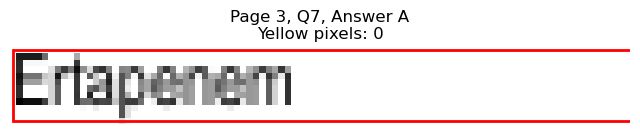

Page 3, Q7 - B: Detected box: x0=68.3, y0=570.8, x1=176.9, y1=581.8
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 527
Page 3, Q7, B: Yellow percentage: 0.0%


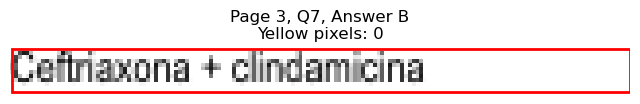

Page 3, Q7 - C: Detected box: x0=327.5, y0=558.2, x1=427.1, y1=569.2
Page 3, Q7, C: Yellow pixels: 151
Page 3, Q7, C: Total non-white pixels: 595
Page 3, Q7, C: Yellow percentage: 25.4%


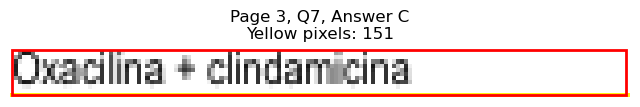

Page 3, Q7 - D: Detected box: x0=327.5, y0=570.8, x1=486.4, y1=581.8
Page 3, Q7, D: Yellow pixels: 1943
Page 3, Q7, D: Total non-white pixels: 2520
Page 3, Q7, D: Yellow percentage: 77.1%


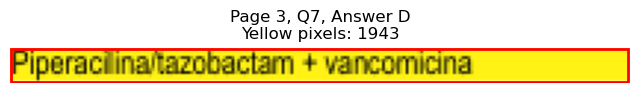


Page 3, Q7 - Selected Answer: D (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=646.5, x1=173.6, y1=657.6
Page 3, Q8, A: Yellow pixels: 1288
Page 3, Q8, A: Total non-white pixels: 1872
Page 3, Q8, A: Yellow percentage: 68.8%


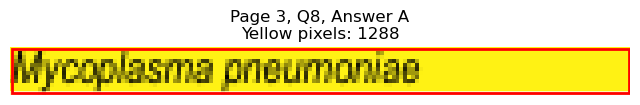

Page 3, Q8 - B: Detected box: x0=68.3, y0=659.1, x1=180.2, y1=670.2
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 572
Page 3, Q8, B: Yellow percentage: 0.0%


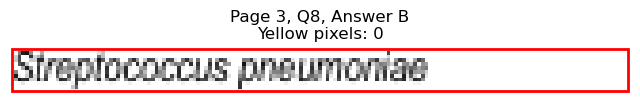

Page 3, Q8 - C: Detected box: x0=327.5, y0=646.5, x1=430.3, y1=657.6
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 521
Page 3, Q8, C: Yellow percentage: 0.0%


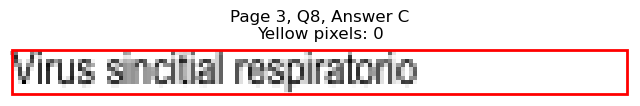

Page 3, Q8 - D: Detected box: x0=327.5, y0=659.1, x1=450.8, y1=670.2
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 621
Page 3, Q8, D: Yellow percentage: 0.0%


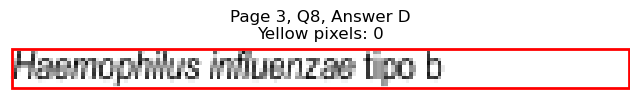


Page 3, Q8 - Selected Answer: A (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=68.3, y0=722.2, x1=137.5, y1=733.3
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 366
Page 3, Q9, A: Yellow percentage: 0.0%


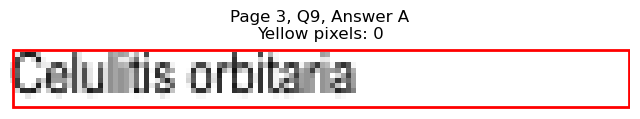

Page 3, Q9 - B: Detected box: x0=68.3, y0=734.8, x1=122.4, y1=745.9
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 289
Page 3, Q9, B: Yellow percentage: 0.0%


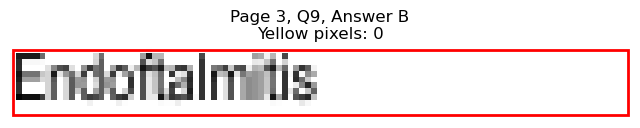

Page 3, Q9 - C: Detected box: x0=327.5, y0=722.2, x1=401.2, y1=733.3
Page 3, Q9, C: Yellow pixels: 1066
Page 3, Q9, C: Total non-white pixels: 1500
Page 3, Q9, C: Yellow percentage: 71.1%


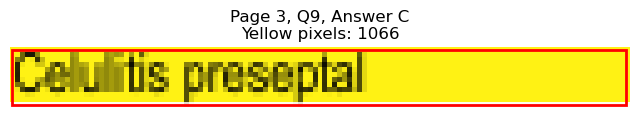

Page 3, Q9 - D: Detected box: x0=327.5, y0=734.8, x1=381.1, y1=745.9
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 275
Page 3, Q9, D: Yellow percentage: 0.0%


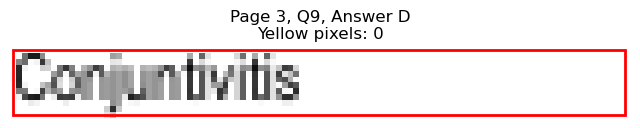


Page 3, Q9 - Selected Answer: C (based on yellow pixel count)





Page 4: Found 9 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=147.5, y1=114.8
Page 4, Q1, A: Yellow pixels: 130
Page 4, Q1, A: Total non-white pixels: 522
Page 4, Q1, A: Yellow percentage: 24.9%


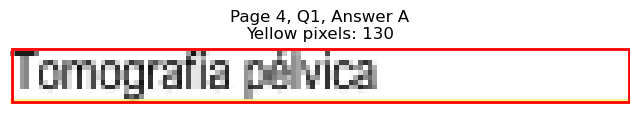

Page 4, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=183.6, y1=127.4
Page 4, Q1, B: Yellow pixels: 1363
Page 4, Q1, B: Total non-white pixels: 1992
Page 4, Q1, B: Yellow percentage: 68.4%


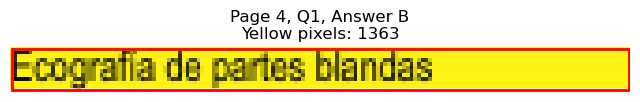

Page 4, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=398.2, y1=114.8
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 369
Page 4, Q1, C: Yellow percentage: 0.0%


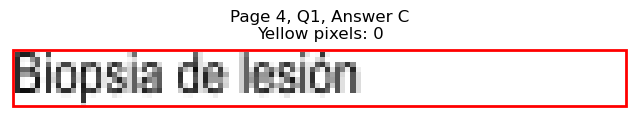

Page 4, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=444.4, y1=127.4
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 615
Page 4, Q1, D: Yellow percentage: 0.0%


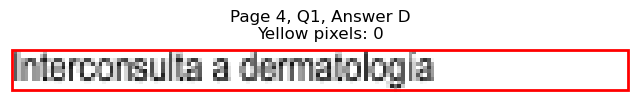


Page 4, Q1 - Selected Answer: B (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=239.9, y1=190.5
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 860
Page 4, Q2, A: Yellow percentage: 0.0%


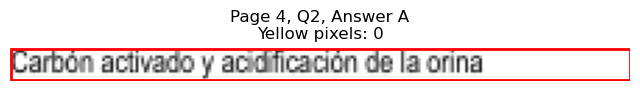

Page 4, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=156.6, y1=203.1
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 455
Page 4, Q2, B: Yellow percentage: 0.0%


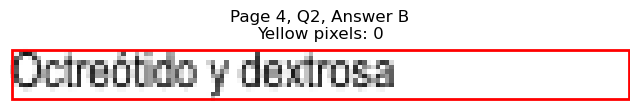

Page 4, Q2 - C: Detected box: x0=327.5, y0=179.5, x1=436.3, y1=190.5
Page 4, Q2, C: Yellow pixels: 160
Page 4, Q2, C: Total non-white pixels: 714
Page 4, Q2, C: Yellow percentage: 22.4%


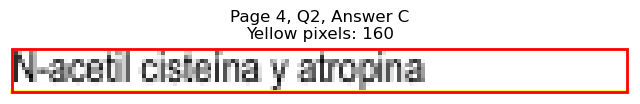

Page 4, Q2 - D: Detected box: x0=327.5, y0=192.1, x1=503.5, y1=203.1
Page 4, Q2, D: Yellow pixels: 1672
Page 4, Q2, D: Total non-white pixels: 2345
Page 4, Q2, D: Yellow percentage: 71.3%


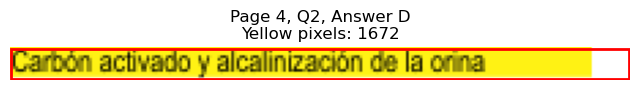


Page 4, Q2 - Selected Answer: D (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=267.8, x1=246.5, y1=278.8
Page 4, Q3, A: Yellow pixels: 1857
Page 4, Q3, A: Total non-white pixels: 2568
Page 4, Q3, A: Yellow percentage: 72.3%


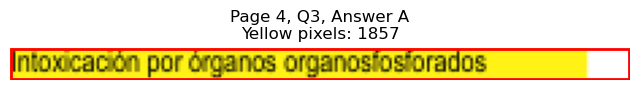

Page 4, Q3 - B: Detected box: x0=68.3, y0=280.5, x1=119.9, y1=291.6
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 267
Page 4, Q3, B: Yellow percentage: 0.0%


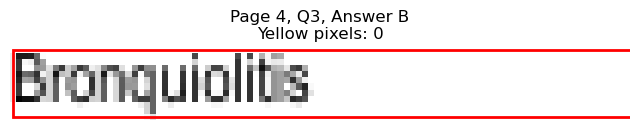

Page 4, Q3 - C: Detected box: x0=327.5, y0=267.8, x1=447.4, y1=278.8
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 597
Page 4, Q3, C: Yellow percentage: 0.0%


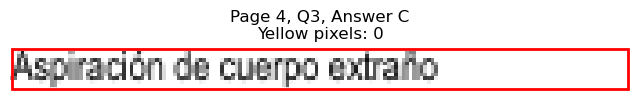

Page 4, Q3 - D: Detected box: x0=327.5, y0=280.5, x1=355.1, y1=291.6
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 138
Page 4, Q3, D: Yellow percentage: 0.0%


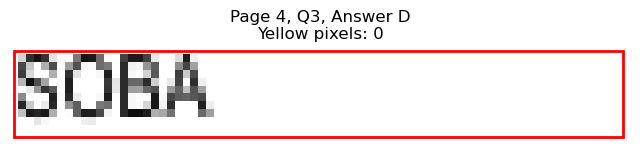


Page 4, Q3 - Selected Answer: A (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=343.6, x1=159.7, y1=354.7
Page 4, Q4, A: Yellow pixels: 1346
Page 4, Q4, A: Total non-white pixels: 1704
Page 4, Q4, A: Yellow percentage: 79.0%


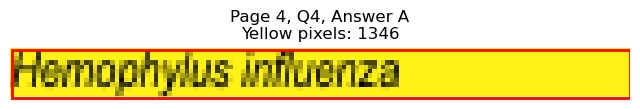

Page 4, Q4 - B: Detected box: x0=68.3, y0=356.2, x1=175.6, y1=367.3
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 545
Page 4, Q4, B: Yellow percentage: 0.0%


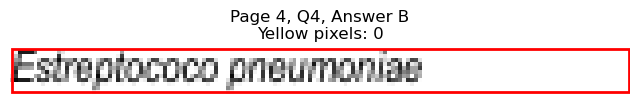

Page 4, Q4 - C: Detected box: x0=327.5, y0=343.6, x1=413.3, y1=354.7
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 455
Page 4, Q4, C: Yellow percentage: 0.0%


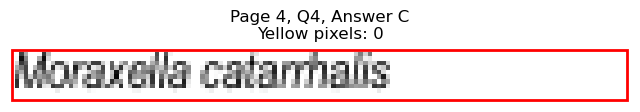

Page 4, Q4 - D: Detected box: x0=327.5, y0=356.2, x1=424.3, y1=367.3
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 505
Page 4, Q4, D: Yellow percentage: 0.0%


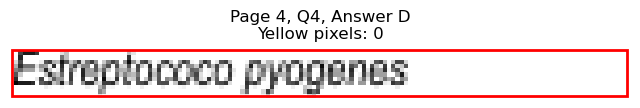


Page 4, Q4 - Selected Answer: A (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=432.0, x1=182.2, y1=443.0
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 776
Page 4, Q5, A: Yellow percentage: 0.0%


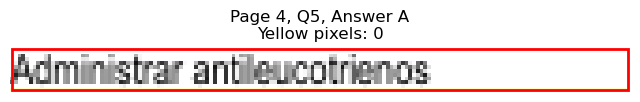

Page 4, Q5 - B: Detected box: x0=68.3, y0=444.6, x1=190.7, y1=455.6
Page 4, Q5, B: Yellow pixels: 1395
Page 4, Q5, B: Total non-white pixels: 2076
Page 4, Q5, B: Yellow percentage: 67.2%


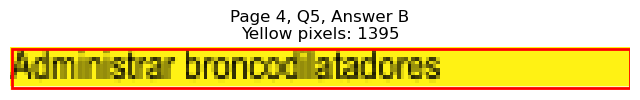

Page 4, Q5 - C: Detected box: x0=327.5, y0=432.0, x1=443.9, y1=443.0
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 570
Page 4, Q5, C: Yellow percentage: 0.0%


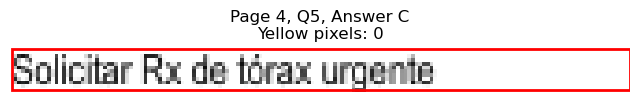

Page 4, Q5 - D: Detected box: x0=327.5, y0=444.6, x1=465.8, y1=455.6
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 715
Page 4, Q5, D: Yellow percentage: 0.0%


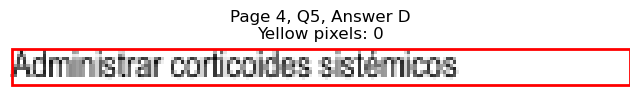


Page 4, Q5 - Selected Answer: B (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=520.3, x1=110.4, y1=531.3
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 221
Page 4, Q6, A: Yellow percentage: 0.0%


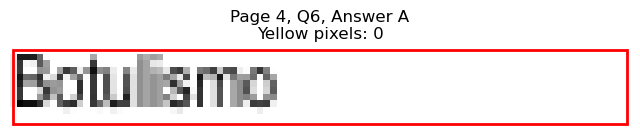

Page 4, Q6 - B: Detected box: x0=68.3, y0=532.9, x1=147.5, y1=543.9
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 419
Page 4, Q6, B: Yellow percentage: 0.0%


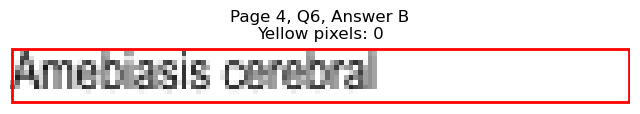

Page 4, Q6 - C: Detected box: x0=327.5, y0=520.3, x1=395.6, y1=531.3
Page 4, Q6, C: Yellow pixels: 119
Page 4, Q6, C: Total non-white pixels: 489
Page 4, Q6, C: Yellow percentage: 24.3%


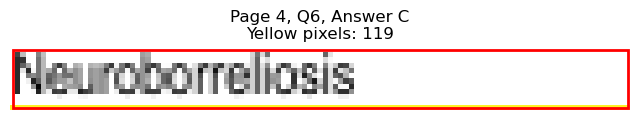

Page 4, Q6 - D: Detected box: x0=327.5, y0=532.9, x1=353.6, y1=543.9
Page 4, Q6, D: Yellow pixels: 806
Page 4, Q6, D: Total non-white pixels: 924
Page 4, Q6, D: Yellow percentage: 87.2%


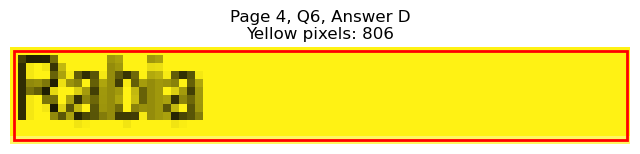


Page 4, Q6 - Selected Answer: D (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=583.4, x1=245.4, y1=594.4
Page 4, Q7, A: Yellow pixels: 1672
Page 4, Q7, A: Total non-white pixels: 2568
Page 4, Q7, A: Yellow percentage: 65.1%


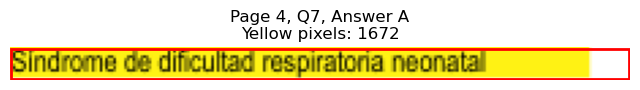

Page 4, Q7 - B: Detected box: x0=68.3, y0=596.0, x1=251.9, y1=607.0
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 901
Page 4, Q7, B: Yellow percentage: 0.0%


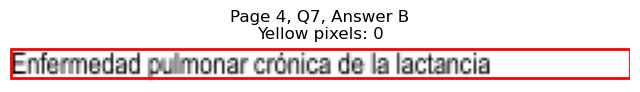

Page 4, Q7 - C: Detected box: x0=327.5, y0=583.4, x1=485.4, y1=594.4
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 839
Page 4, Q7, C: Yellow percentage: 0.0%


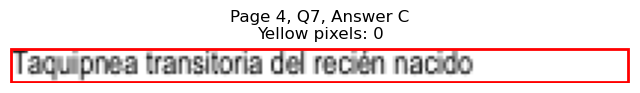

Page 4, Q7 - D: Detected box: x0=327.5, y0=596.0, x1=474.5, y1=607.0
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 743
Page 4, Q7, D: Yellow percentage: 0.0%


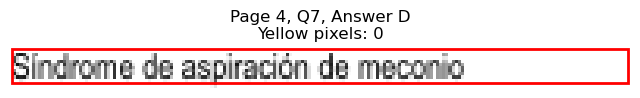


Page 4, Q7 - Selected Answer: A (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=646.5, x1=109.4, y1=657.6
Page 4, Q8, A: Yellow pixels: 832
Page 4, Q8, A: Total non-white pixels: 1104
Page 4, Q8, A: Yellow percentage: 75.4%


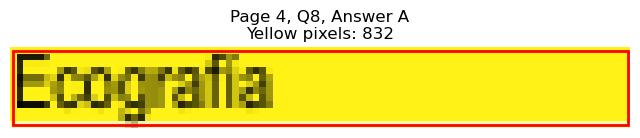

Page 4, Q8 - B: Detected box: x0=68.3, y0=659.1, x1=117.5, y1=670.2
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 285
Page 4, Q8, B: Yellow percentage: 0.0%


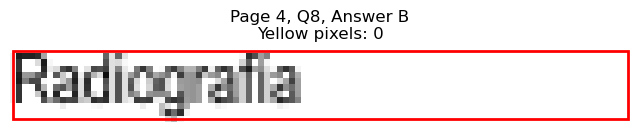

Page 4, Q8 - C: Detected box: x0=327.5, y0=646.5, x1=376.1, y1=657.6
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 245
Page 4, Q8, C: Yellow percentage: 0.0%


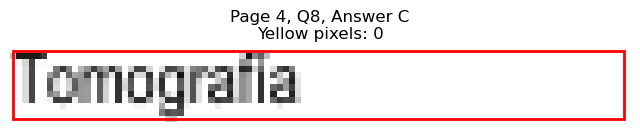

Page 4, Q8 - D: Detected box: x0=327.5, y0=659.1, x1=377.6, y1=670.2
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 253
Page 4, Q8, D: Yellow percentage: 0.0%


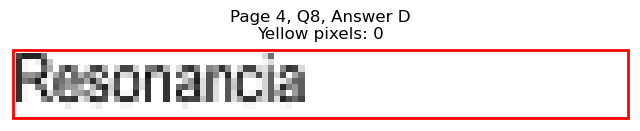


Page 4, Q8 - Selected Answer: A (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=722.2, x1=133.4, y1=733.3
Page 4, Q9, A: Yellow pixels: 116
Page 4, Q9, A: Total non-white pixels: 452
Page 4, Q9, A: Yellow percentage: 25.7%


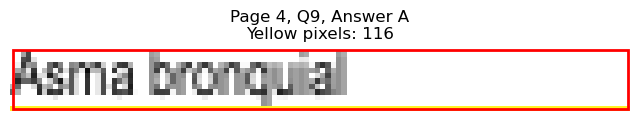

Page 4, Q9 - B: Detected box: x0=68.3, y0=734.8, x1=238.3, y1=745.9
Page 4, Q9, B: Yellow pixels: 1937
Page 4, Q9, B: Total non-white pixels: 2568
Page 4, Q9, B: Yellow percentage: 75.4%


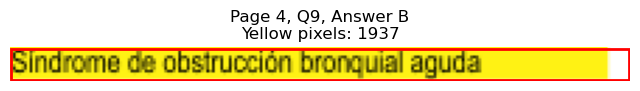

Page 4, Q9 - C: Detected box: x0=327.5, y0=722.2, x1=379.1, y1=733.3
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 266
Page 4, Q9, C: Yellow percentage: 0.0%


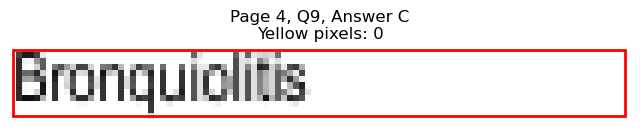

Page 4, Q9 - D: Detected box: x0=327.5, y0=734.8, x1=395.3, y1=745.9
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 358
Page 4, Q9, D: Yellow percentage: 0.0%


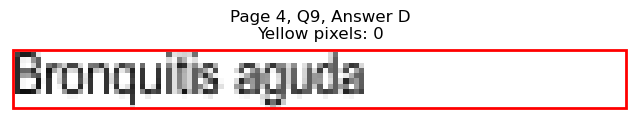


Page 4, Q9 - Selected Answer: B (based on yellow pixel count)





Page 5: Found 9 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=372.1, y1=127.4
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 1588
Page 5, Q1, A: Yellow percentage: 0.0%


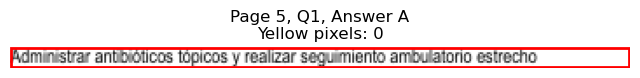

Page 5, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=373.7, y1=140.0
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 1872
Page 5, Q1, B: Yellow percentage: 0.0%


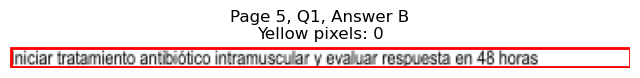

Page 5, Q1 - C: Detected box: x0=68.8, y0=141.7, x1=370.7, y1=152.7
Page 5, Q1, C: Yellow pixels: 3027
Page 5, Q1, C: Total non-white pixels: 4236
Page 5, Q1, C: Yellow percentage: 71.5%


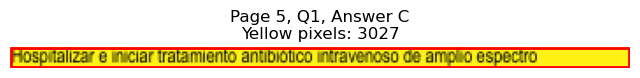

Page 5, Q1 - D: Detected box: x0=68.8, y0=154.3, x1=356.6, y1=165.3
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 1472
Page 5, Q1, D: Yellow percentage: 0.0%


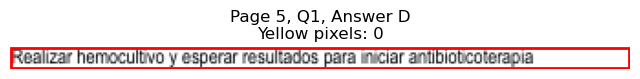


Page 5, Q1 - Selected Answer: C (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=204.7, x1=173.6, y1=215.7
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 764
Page 5, Q2, A: Yellow percentage: 0.0%


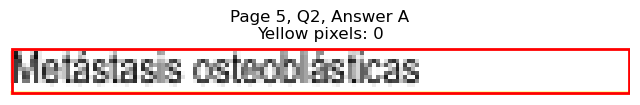

Page 5, Q2 - B: Detected box: x0=68.3, y0=217.4, x1=122.4, y1=228.4
Page 5, Q2, B: Yellow pixels: 916
Page 5, Q2, B: Total non-white pixels: 1260
Page 5, Q2, B: Yellow percentage: 72.7%


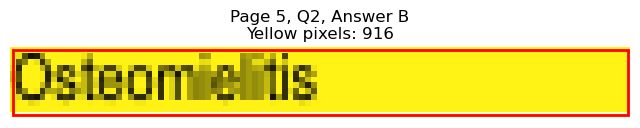

Page 5, Q2 - C: Detected box: x0=327.5, y0=204.7, x1=407.9, y1=215.7
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 407
Page 5, Q2, C: Yellow percentage: 0.0%


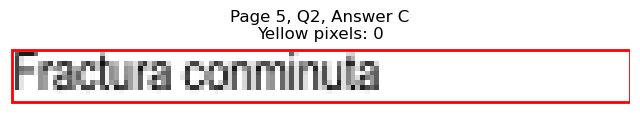

Page 5, Q2 - D: Detected box: x0=327.5, y0=217.4, x1=383.2, y1=228.4
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 285
Page 5, Q2, D: Yellow percentage: 0.0%


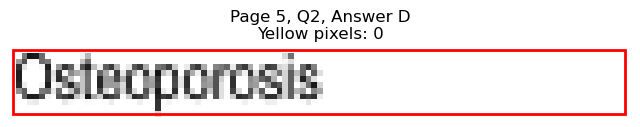


Page 5, Q2 - Selected Answer: B (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=280.5, x1=80.9, y1=291.6
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 67
Page 5, Q3, A: Yellow percentage: 0.0%


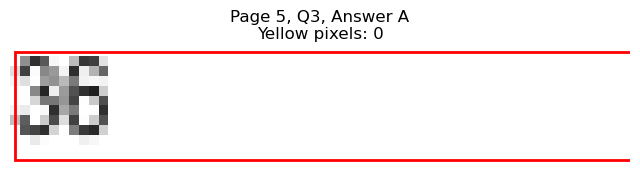

Page 5, Q3 - B: Detected box: x0=68.3, y0=293.1, x1=80.9, y1=304.2
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 59
Page 5, Q3, B: Yellow percentage: 0.0%


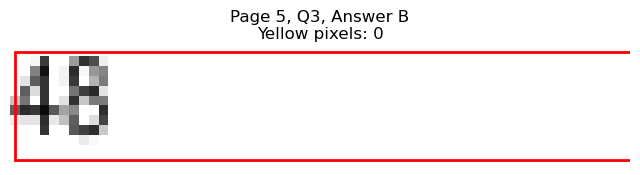

Page 5, Q3 - C: Detected box: x0=327.5, y0=280.5, x1=340.1, y1=291.6
Page 5, Q3, C: Yellow pixels: 661
Page 5, Q3, C: Total non-white pixels: 768
Page 5, Q3, C: Yellow percentage: 86.1%


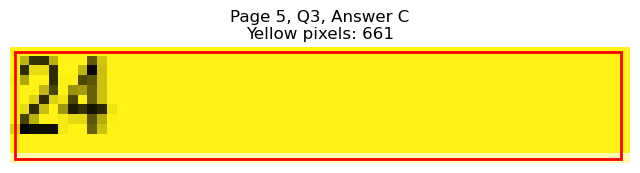

Page 5, Q3 - D: Detected box: x0=327.5, y0=293.1, x1=340.1, y1=304.2
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 48
Page 5, Q3, D: Yellow percentage: 0.0%


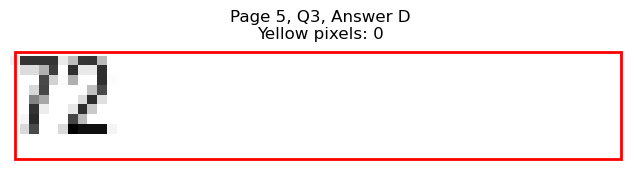


Page 5, Q3 - Selected Answer: C (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=356.2, x1=126.0, y1=367.3
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 331
Page 5, Q4, A: Yellow percentage: 0.0%


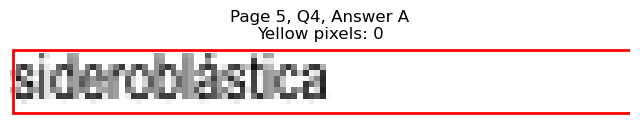

Page 5, Q4 - B: Detected box: x0=68.3, y0=368.8, x1=115.9, y1=379.9
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 248
Page 5, Q4, B: Yellow percentage: 0.0%


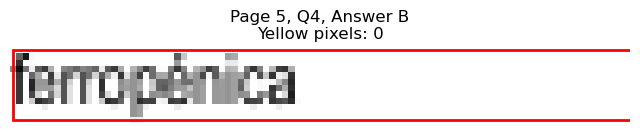

Page 5, Q4 - C: Detected box: x0=327.5, y0=356.2, x1=390.1, y1=367.3
Page 5, Q4, C: Yellow pixels: 967
Page 5, Q4, C: Total non-white pixels: 1368
Page 5, Q4, C: Yellow percentage: 70.7%


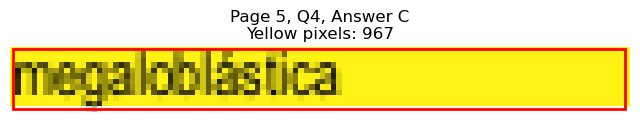

Page 5, Q4 - D: Detected box: x0=327.5, y0=368.8, x1=374.6, y1=379.9
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 225
Page 5, Q4, D: Yellow percentage: 0.0%


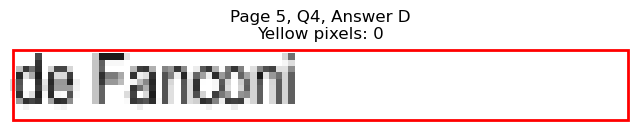


Page 5, Q4 - Selected Answer: C (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=432.0, x1=135.0, y1=443.0
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 353
Page 5, Q5, A: Yellow percentage: 0.0%


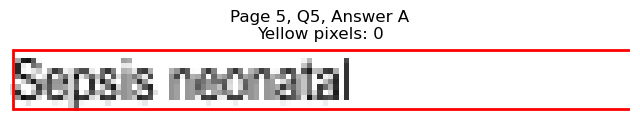

Page 5, Q5 - B: Detected box: x0=68.3, y0=444.6, x1=139.0, y1=455.6
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 346
Page 5, Q5, B: Yellow percentage: 0.0%


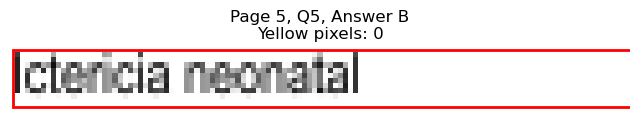

Page 5, Q5 - C: Detected box: x0=327.5, y0=432.0, x1=381.6, y1=443.0
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 403
Page 5, Q5, C: Yellow percentage: 0.0%


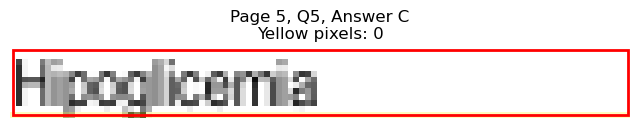

Page 5, Q5 - D: Detected box: x0=327.5, y0=444.6, x1=452.4, y1=455.6
Page 5, Q5, D: Yellow pixels: 1463
Page 5, Q5, D: Total non-white pixels: 2112
Page 5, Q5, D: Yellow percentage: 69.3%


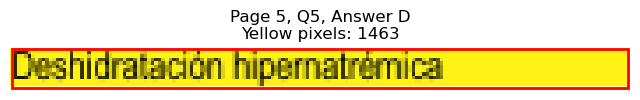


Page 5, Q5 - Selected Answer: D (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=520.3, x1=165.1, y1=531.3
Page 5, Q6, A: Yellow pixels: 148
Page 5, Q6, A: Total non-white pixels: 689
Page 5, Q6, A: Yellow percentage: 21.5%


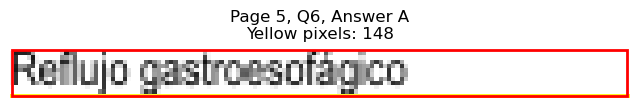

Page 5, Q6 - B: Detected box: x0=68.3, y0=532.9, x1=124.0, y1=543.9
Page 5, Q6, B: Yellow pixels: 1069
Page 5, Q6, B: Total non-white pixels: 1272
Page 5, Q6, B: Yellow percentage: 84.0%


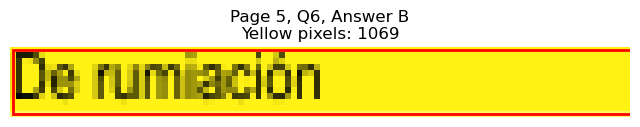

Page 5, Q6 - C: Detected box: x0=327.5, y0=520.3, x1=400.2, y1=531.3
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 386
Page 5, Q6, C: Yellow percentage: 0.0%


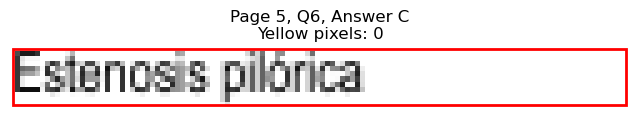

Page 5, Q6 - D: Detected box: x0=327.5, y0=532.9, x1=396.2, y1=543.9
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 328
Page 5, Q6, D: Yellow percentage: 0.0%


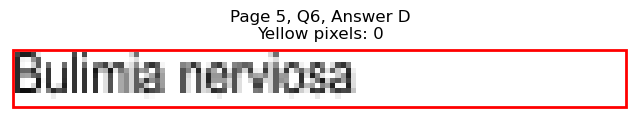


Page 5, Q6 - Selected Answer: B (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=583.4, x1=141.0, y1=594.4
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 362
Page 5, Q7, A: Yellow percentage: 0.0%


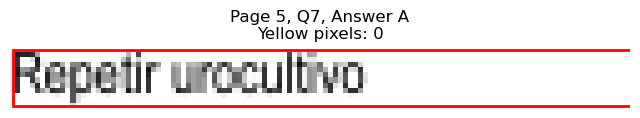

Page 5, Q7 - B: Detected box: x0=68.3, y0=596.0, x1=143.0, y1=607.0
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 396
Page 5, Q7, B: Yellow percentage: 0.0%


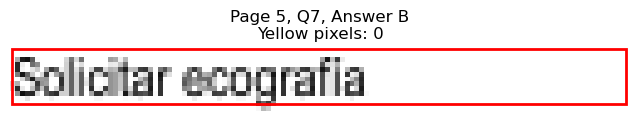

Page 5, Q7 - C: Detected box: x0=327.5, y0=583.4, x1=444.8, y1=594.4
Page 5, Q7, C: Yellow pixels: 1381
Page 5, Q7, C: Total non-white pixels: 2016
Page 5, Q7, C: Yellow percentage: 68.5%


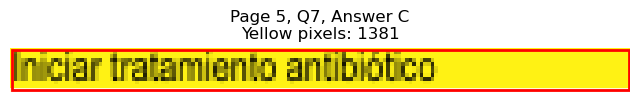

Page 5, Q7 - D: Detected box: x0=327.5, y0=596.0, x1=407.8, y1=607.0
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 437
Page 5, Q7, D: Yellow percentage: 0.0%


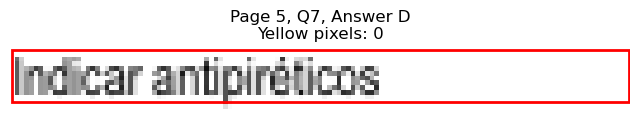


Page 5, Q7 - Selected Answer: C (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=659.1, x1=230.2, y1=670.2
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 882
Page 5, Q8, A: Yellow percentage: 0.0%


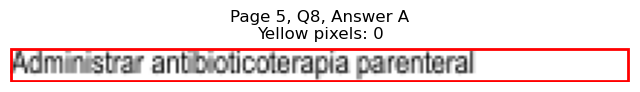

Page 5, Q8 - B: Detected box: x0=68.3, y0=671.7, x1=314.0, y1=682.8
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 1239
Page 5, Q8, B: Yellow percentage: 0.0%


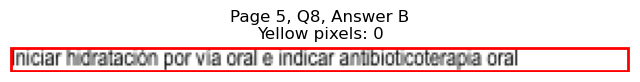

Page 5, Q8 - C: Detected box: x0=68.8, y0=684.3, x1=263.8, y1=695.4
Page 5, Q8, C: Yellow pixels: 246
Page 5, Q8, C: Total non-white pixels: 1247
Page 5, Q8, C: Yellow percentage: 19.7%


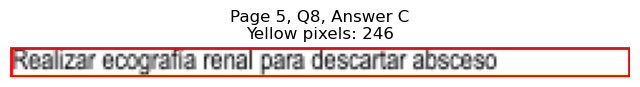

Page 5, Q8 - D: Detected box: x0=68.8, y0=697.0, x1=306.6, y1=708.1
Page 5, Q8, D: Yellow pixels: 2224
Page 5, Q8, D: Total non-white pixels: 3187
Page 5, Q8, D: Yellow percentage: 69.8%


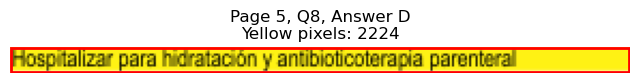


Page 5, Q8 - Selected Answer: D (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=734.8, x1=127.4, y1=745.9
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 272
Page 5, Q9, A: Yellow percentage: 0.0%


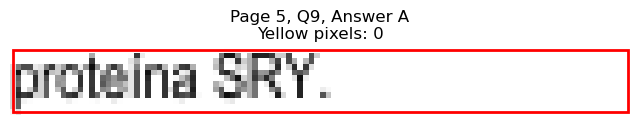

Page 5, Q9 - B: Detected box: x0=68.3, y0=747.4, x1=149.5, y1=758.5
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 386
Page 5, Q9, B: Yellow percentage: 0.0%


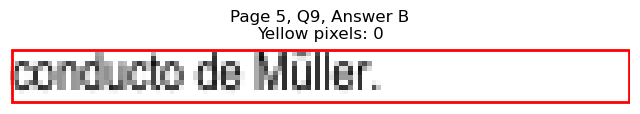

Page 5, Q9 - C: Detected box: x0=327.5, y0=734.8, x1=404.8, y1=745.9
Page 5, Q9, C: Yellow pixels: 1245
Page 5, Q9, C: Total non-white pixels: 1536
Page 5, Q9, C: Yellow percentage: 81.1%


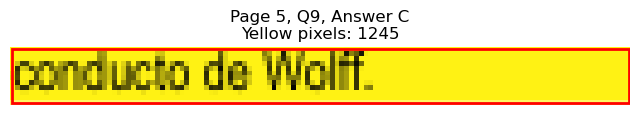

Page 5, Q9 - D: Detected box: x0=327.5, y0=747.4, x1=384.7, y1=758.5
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 272
Page 5, Q9, D: Yellow percentage: 0.0%


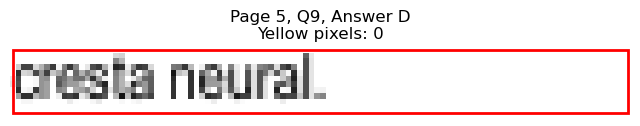


Page 5, Q9 - Selected Answer: C (based on yellow pixel count)





Page 6: Found 9 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=171.1, y1=102.2
Page 6, Q1, A: Yellow pixels: 154
Page 6, Q1, A: Total non-white pixels: 804
Page 6, Q1, A: Yellow percentage: 19.2%


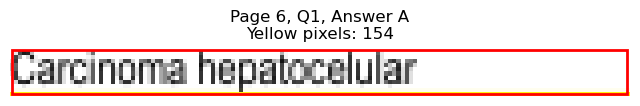

Page 6, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=136.4, y1=114.8
Page 6, Q1, B: Yellow pixels: 1159
Page 6, Q1, B: Total non-white pixels: 1428
Page 6, Q1, B: Yellow percentage: 81.2%


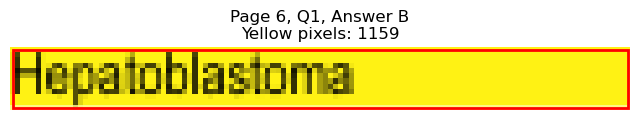

Page 6, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=377.2, y1=102.2
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 246
Page 6, Q1, C: Yellow percentage: 0.0%


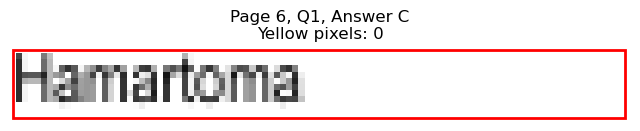

Page 6, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=420.2, y1=114.8
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 497
Page 6, Q1, D: Yellow percentage: 0.0%


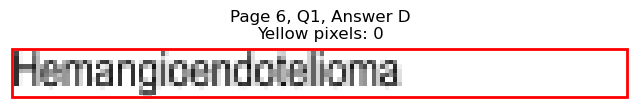


Page 6, Q1 - Selected Answer: B (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=141.7, x1=115.0, y1=152.7
Page 6, Q2, A: Yellow pixels: 0
Page 6, Q2, A: Total non-white pixels: 258
Page 6, Q2, A: Yellow percentage: 0.0%


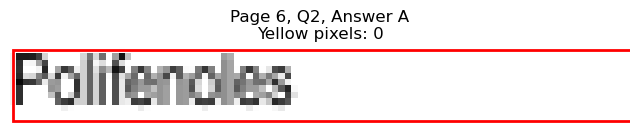

Page 6, Q2 - B: Detected box: x0=68.3, y0=154.3, x1=106.4, y1=165.3
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 205
Page 6, Q2, B: Yellow percentage: 0.0%


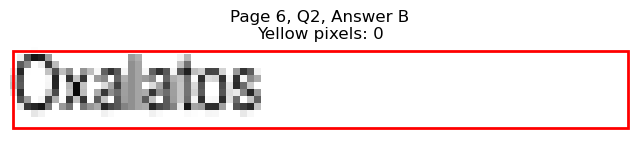

Page 6, Q2 - C: Detected box: x0=327.5, y0=141.7, x1=355.1, y1=152.7
Page 6, Q2, C: Yellow pixels: 79
Page 6, Q2, C: Total non-white pixels: 212
Page 6, Q2, C: Yellow percentage: 37.3%


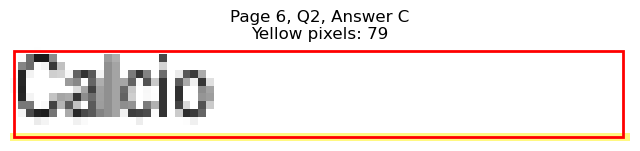

Page 6, Q2 - D: Detected box: x0=327.5, y0=154.3, x1=365.0, y1=165.3
Page 6, Q2, D: Yellow pixels: 837
Page 6, Q2, D: Total non-white pixels: 1068
Page 6, Q2, D: Yellow percentage: 78.4%


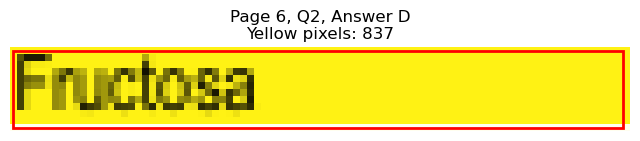


Page 6, Q2 - Selected Answer: D (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=192.1, x1=158.5, y1=203.1
Page 6, Q3, A: Yellow pixels: 1156
Page 6, Q3, A: Total non-white pixels: 1555
Page 6, Q3, A: Yellow percentage: 74.3%


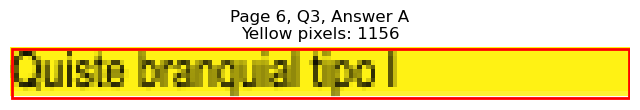

Page 6, Q3 - B: Detected box: x0=68.3, y0=204.7, x1=99.4, y1=215.7
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 168
Page 6, Q3, B: Yellow percentage: 0.0%


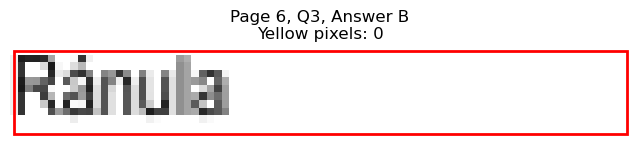

Page 6, Q3 - C: Detected box: x0=327.5, y0=192.1, x1=396.7, y1=203.1
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 348
Page 6, Q3, C: Yellow percentage: 0.0%


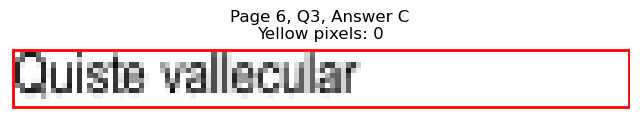

Page 6, Q3 - D: Detected box: x0=327.5, y0=204.7, x1=396.1, y1=215.7
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 332
Page 6, Q3, D: Yellow percentage: 0.0%


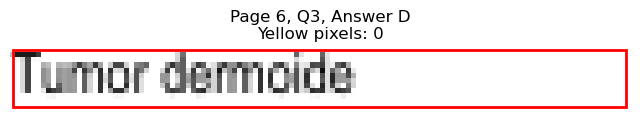


Page 6, Q3 - Selected Answer: A (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=280.5, x1=165.6, y1=291.6
Page 6, Q4, A: Yellow pixels: 1267
Page 6, Q4, A: Total non-white pixels: 1776
Page 6, Q4, A: Yellow percentage: 71.3%


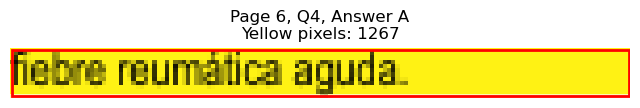

Page 6, Q4 - B: Detected box: x0=68.3, y0=293.1, x1=139.4, y1=304.2
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 376
Page 6, Q4, B: Yellow percentage: 0.0%


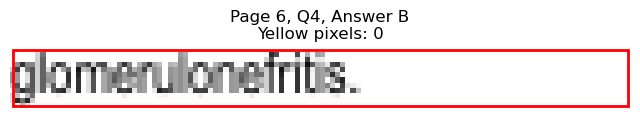

Page 6, Q4 - C: Detected box: x0=327.5, y0=280.5, x1=432.4, y1=291.6
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 558
Page 6, Q4, C: Yellow percentage: 0.0%


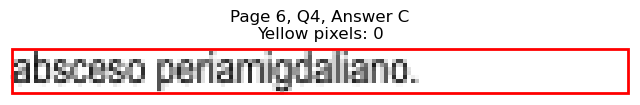

Page 6, Q4 - D: Detected box: x0=327.5, y0=293.1, x1=396.7, y1=304.2
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 344
Page 6, Q4, D: Yellow percentage: 0.0%


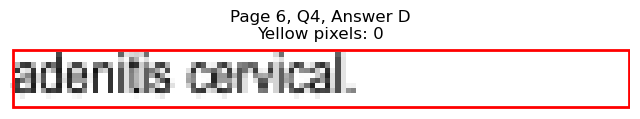


Page 6, Q4 - Selected Answer: A (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=368.8, x1=116.0, y1=379.9
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 246
Page 6, Q5, A: Yellow percentage: 0.0%


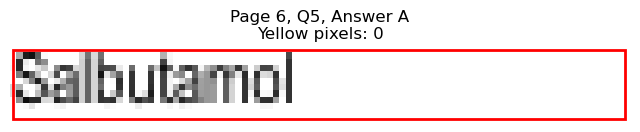

Page 6, Q5 - B: Detected box: x0=68.3, y0=381.4, x1=131.5, y1=392.5
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 329
Page 6, Q5, B: Yellow percentage: 0.0%


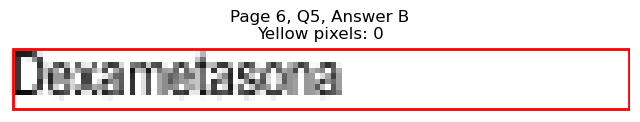

Page 6, Q5 - C: Detected box: x0=327.5, y0=368.8, x1=373.2, y1=379.9
Page 6, Q5, C: Yellow pixels: 1008
Page 6, Q5, C: Total non-white pixels: 1164
Page 6, Q5, C: Yellow percentage: 86.6%


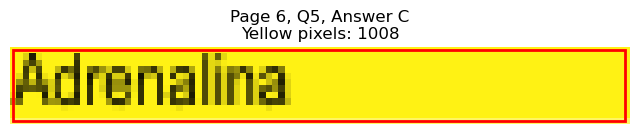

Page 6, Q5 - D: Detected box: x0=327.5, y0=381.4, x1=388.8, y1=392.5
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 316
Page 6, Q5, D: Yellow percentage: 0.0%


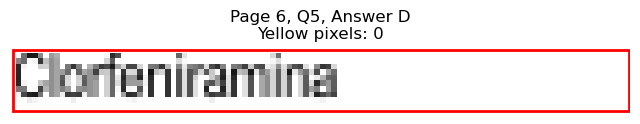


Page 6, Q5 - Selected Answer: C (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=457.2, x1=107.9, y1=468.2
Page 6, Q6, A: Yellow pixels: 90
Page 6, Q6, A: Total non-white pixels: 383
Page 6, Q6, A: Yellow percentage: 23.5%


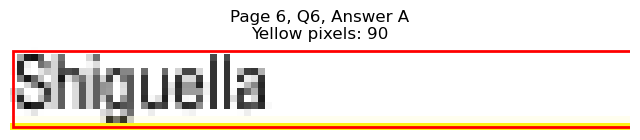

Page 6, Q6 - B: Detected box: x0=68.3, y0=469.8, x1=131.5, y1=480.8
Page 6, Q6, B: Yellow pixels: 1107
Page 6, Q6, B: Total non-white pixels: 1368
Page 6, Q6, B: Yellow percentage: 80.9%


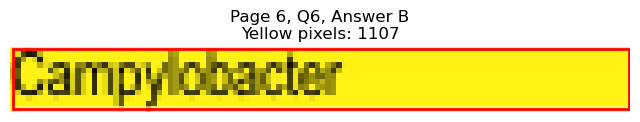

Page 6, Q6 - C: Detected box: x0=327.5, y0=457.2, x1=374.6, y1=468.2
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 245
Page 6, Q6, C: Yellow percentage: 0.0%


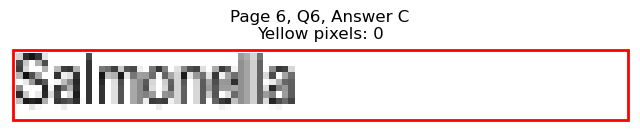

Page 6, Q6 - D: Detected box: x0=327.5, y0=469.8, x1=358.6, y1=480.8
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 153
Page 6, Q6, D: Yellow percentage: 0.0%


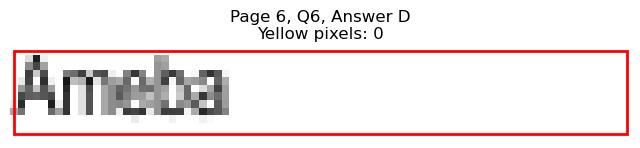


Page 6, Q6 - Selected Answer: B (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=532.9, x1=150.0, y1=543.9
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 373
Page 6, Q7, A: Yellow percentage: 0.0%


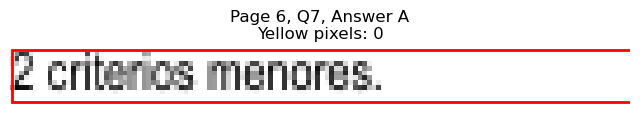

Page 6, Q7 - B: Detected box: x0=68.3, y0=545.5, x1=135.5, y1=556.5
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 292
Page 6, Q7, B: Yellow percentage: 0.0%


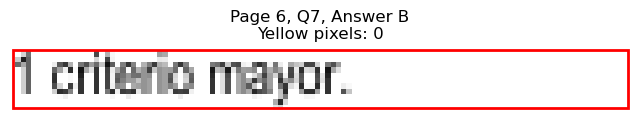

Page 6, Q7 - C: Detected box: x0=327.5, y0=532.9, x1=408.7, y1=543.9
Page 6, Q7, C: Yellow pixels: 1
Page 6, Q7, C: Total non-white pixels: 513
Page 6, Q7, C: Yellow percentage: 0.2%


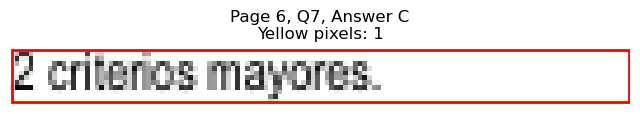

Page 6, Q7 - D: Detected box: x0=327.5, y0=545.5, x1=395.2, y1=556.5
Page 6, Q7, D: Yellow pixels: 1091
Page 6, Q7, D: Total non-white pixels: 1428
Page 6, Q7, D: Yellow percentage: 76.4%


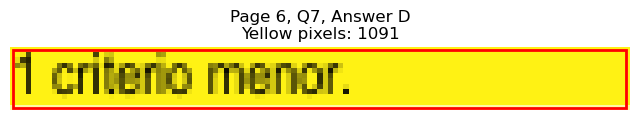


Page 6, Q7 - Selected Answer: D (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=621.3, x1=143.0, y1=632.4
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 365
Page 6, Q8, A: Yellow percentage: 0.0%


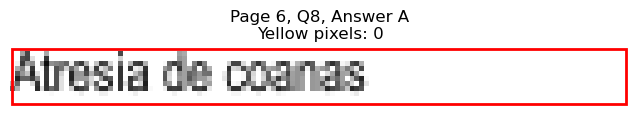

Page 6, Q8 - B: Detected box: x0=68.3, y0=633.9, x1=120.5, y1=645.0
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 268
Page 6, Q8, B: Yellow percentage: 0.0%


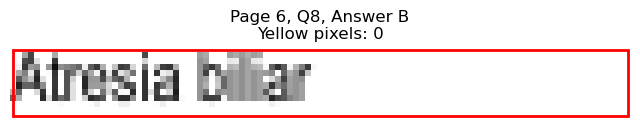

Page 6, Q8 - C: Detected box: x0=327.5, y0=621.3, x1=431.8, y1=632.4
Page 6, Q8, C: Yellow pixels: 155
Page 6, Q8, C: Total non-white pixels: 703
Page 6, Q8, C: Yellow percentage: 22.0%


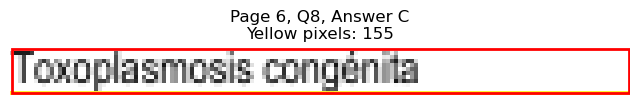

Page 6, Q8 - D: Detected box: x0=327.5, y0=633.9, x1=393.2, y1=645.0
Page 6, Q8, D: Yellow pixels: 1148
Page 6, Q8, D: Total non-white pixels: 1404
Page 6, Q8, D: Yellow percentage: 81.8%


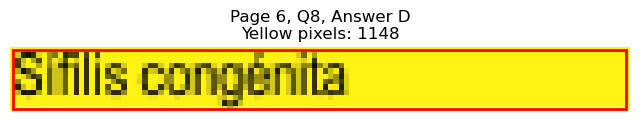


Page 6, Q8 - Selected Answer: D (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=697.0, x1=129.5, y1=708.1
Page 6, Q9, A: Yellow pixels: 997
Page 6, Q9, A: Total non-white pixels: 1232
Page 6, Q9, A: Yellow percentage: 80.9%


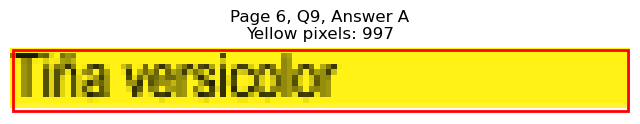

Page 6, Q9 - B: Detected box: x0=68.3, y0=709.6, x1=107.4, y1=720.7
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 203
Page 6, Q9, B: Yellow percentage: 0.0%


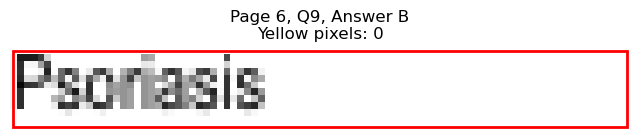

Page 6, Q9 - C: Detected box: x0=327.5, y0=697.0, x1=415.2, y1=708.1
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 458
Page 6, Q9, C: Yellow percentage: 0.0%


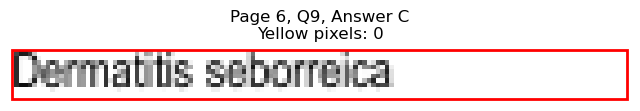

Page 6, Q9 - D: Detected box: x0=327.5, y0=709.6, x1=388.2, y1=720.7
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 328
Page 6, Q9, D: Yellow percentage: 0.0%


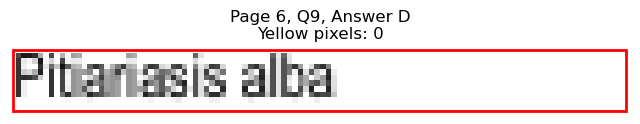


Page 6, Q9 - Selected Answer: A (based on yellow pixel count)





Page 7: Found 9 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=141.7, x1=170.6, y1=152.7
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 522
Page 7, Q1, A: Yellow percentage: 0.0%


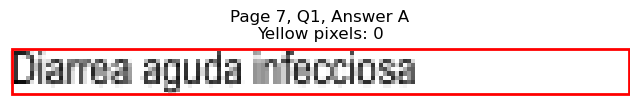

Page 7, Q1 - B: Detected box: x0=68.3, y0=154.3, x1=159.6, y1=165.3
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 460
Page 7, Q1, B: Yellow percentage: 0.0%


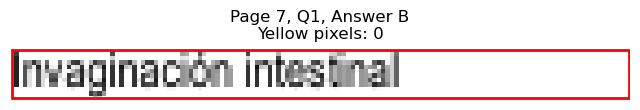

Page 7, Q1 - C: Detected box: x0=327.5, y0=141.7, x1=469.0, y1=152.7
Page 7, Q1, C: Yellow pixels: 1798
Page 7, Q1, C: Total non-white pixels: 2304
Page 7, Q1, C: Yellow percentage: 78.0%


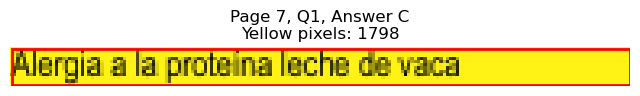

Page 7, Q1 - D: Detected box: x0=327.5, y0=154.3, x1=425.3, y1=165.3
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 509
Page 7, Q1, D: Yellow percentage: 0.0%


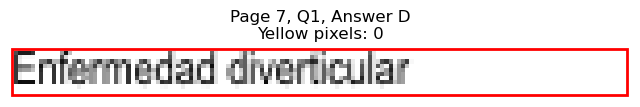


Page 7, Q1 - Selected Answer: C (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=204.7, x1=258.4, y1=215.7
Page 7, Q2, A: Yellow pixels: 2
Page 7, Q2, A: Total non-white pixels: 1193
Page 7, Q2, A: Yellow percentage: 0.2%


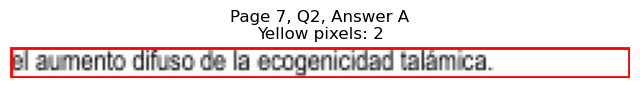

Page 7, Q2 - B: Detected box: x0=68.3, y0=217.4, x1=338.2, y1=228.4
Page 7, Q2, B: Yellow pixels: 2553
Page 7, Q2, B: Total non-white pixels: 3852
Page 7, Q2, B: Yellow percentage: 66.3%


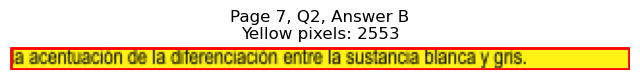

Page 7, Q2 - C: Detected box: x0=68.8, y0=230.0, x1=255.4, y1=241.0
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 927
Page 7, Q2, C: Yellow percentage: 0.0%


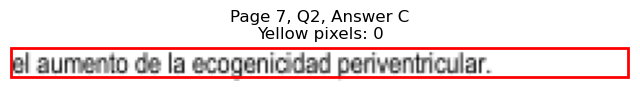

Page 7, Q2 - D: Detected box: x0=68.8, y0=242.6, x1=278.9, y1=253.6
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 1023
Page 7, Q2, D: Yellow percentage: 0.0%


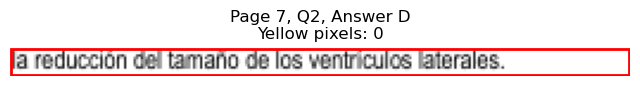


Page 7, Q2 - Selected Answer: B (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=293.1, x1=226.2, y1=304.2
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 810
Page 7, Q3, A: Yellow percentage: 0.0%


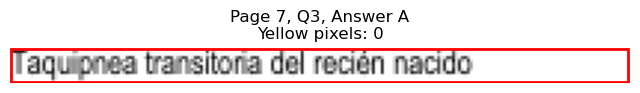

Page 7, Q3 - B: Detected box: x0=68.3, y0=305.7, x1=245.4, y1=316.8
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 917
Page 7, Q3, B: Yellow percentage: 0.0%


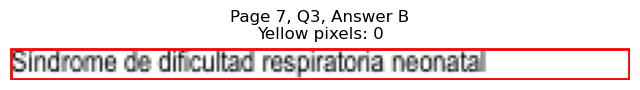

Page 7, Q3 - C: Detected box: x0=327.5, y0=293.1, x1=474.5, y1=304.2
Page 7, Q3, C: Yellow pixels: 1619
Page 7, Q3, C: Total non-white pixels: 2180
Page 7, Q3, C: Yellow percentage: 74.3%


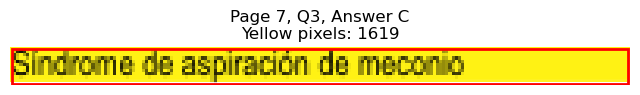

Page 7, Q3 - D: Detected box: x0=327.5, y0=305.7, x1=511.1, y1=316.8
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 914
Page 7, Q3, D: Yellow percentage: 0.0%


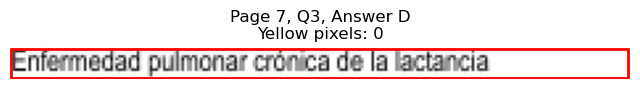


Page 7, Q3 - Selected Answer: C (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=356.2, x1=138.5, y1=367.3
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 367
Page 7, Q4, A: Yellow percentage: 0.0%


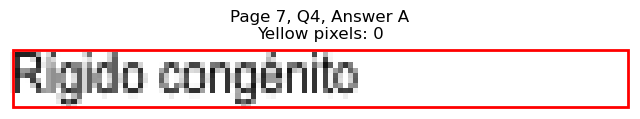

Page 7, Q4 - B: Detected box: x0=68.3, y0=368.8, x1=135.0, y1=379.9
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 311
Page 7, Q4, B: Yellow percentage: 0.0%


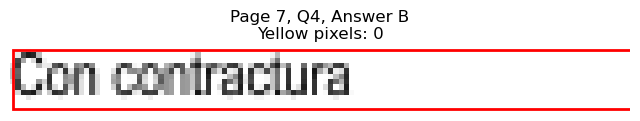

Page 7, Q4 - C: Detected box: x0=327.5, y0=356.2, x1=378.1, y1=367.3
Page 7, Q4, C: Yellow pixels: 102
Page 7, Q4, C: Total non-white pixels: 377
Page 7, Q4, C: Yellow percentage: 27.1%


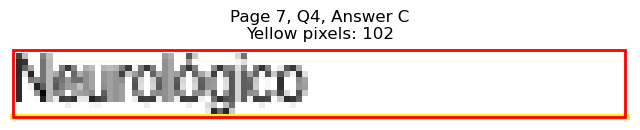

Page 7, Q4 - D: Detected box: x0=327.5, y0=368.8, x1=361.1, y1=379.9
Page 7, Q4, D: Yellow pixels: 886
Page 7, Q4, D: Total non-white pixels: 1020
Page 7, Q4, D: Yellow percentage: 86.9%


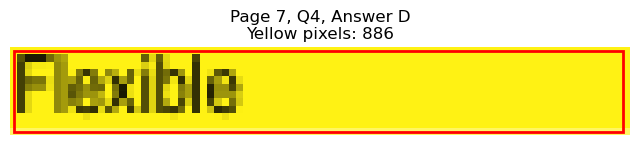


Page 7, Q4 - Selected Answer: D (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=444.6, x1=177.6, y1=455.6
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 522
Page 7, Q5, A: Yellow percentage: 0.0%


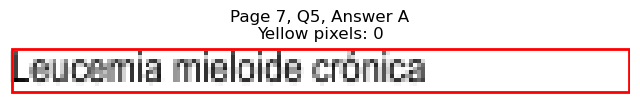

Page 7, Q5 - B: Detected box: x0=68.3, y0=457.2, x1=173.6, y1=468.2
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 518
Page 7, Q5, B: Yellow percentage: 0.0%


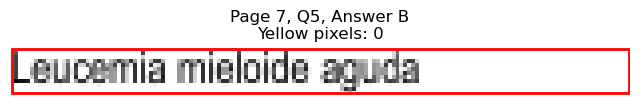

Page 7, Q5 - C: Detected box: x0=327.5, y0=444.6, x1=416.3, y1=455.6
Page 7, Q5, C: Yellow pixels: 140
Page 7, Q5, C: Total non-white pixels: 609
Page 7, Q5, C: Yellow percentage: 23.0%


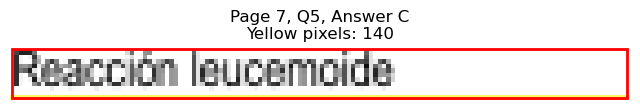

Page 7, Q5 - D: Detected box: x0=327.5, y0=457.2, x1=446.4, y1=468.2
Page 7, Q5, D: Yellow pixels: 1426
Page 7, Q5, D: Total non-white pixels: 1872
Page 7, Q5, D: Yellow percentage: 76.2%


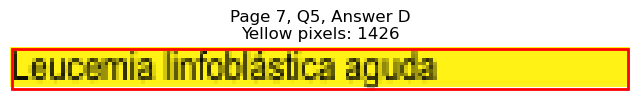


Page 7, Q5 - Selected Answer: D (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=520.3, x1=188.6, y1=531.3
Page 7, Q6, A: Yellow pixels: 1403
Page 7, Q6, A: Total non-white pixels: 2052
Page 7, Q6, A: Yellow percentage: 68.4%


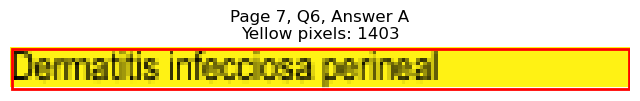

Page 7, Q6 - B: Detected box: x0=68.3, y0=532.9, x1=117.5, y1=543.9
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 271
Page 7, Q6, B: Yellow percentage: 0.0%


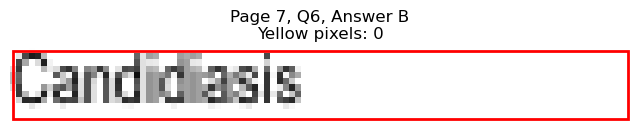

Page 7, Q6 - C: Detected box: x0=327.5, y0=520.3, x1=415.2, y1=531.3
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 458
Page 7, Q6, C: Yellow percentage: 0.0%


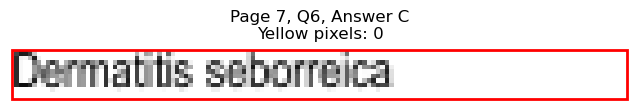

Page 7, Q6 - D: Detected box: x0=327.5, y0=532.9, x1=420.7, y1=543.9
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 467
Page 7, Q6, D: Yellow percentage: 0.0%


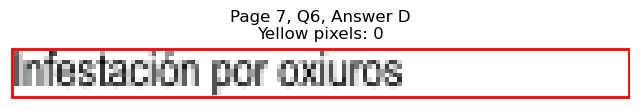


Page 7, Q6 - Selected Answer: A (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=596.0, x1=210.2, y1=607.0
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 695
Page 7, Q7, A: Yellow percentage: 0.0%


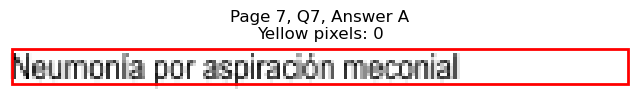

Page 7, Q7 - B: Detected box: x0=68.3, y0=608.6, x1=195.6, y1=619.6
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 638
Page 7, Q7, B: Yellow percentage: 0.0%


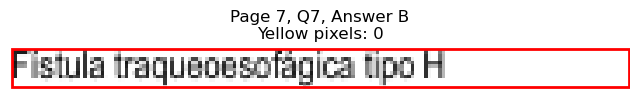

Page 7, Q7 - C: Detected box: x0=327.5, y0=596.0, x1=399.2, y1=607.0
Page 7, Q7, C: Yellow pixels: 1180
Page 7, Q7, C: Total non-white pixels: 1479
Page 7, Q7, C: Yellow percentage: 79.8%


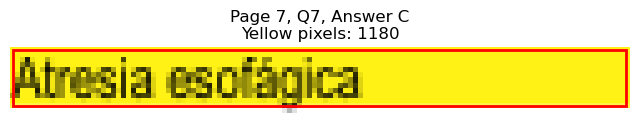

Page 7, Q7 - D: Detected box: x0=327.5, y0=608.6, x1=413.3, y1=619.6
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 479
Page 7, Q7, D: Yellow percentage: 0.0%


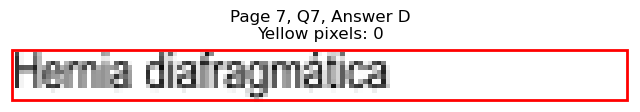


Page 7, Q7 - Selected Answer: C (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=646.5, x1=117.5, y1=657.6
Page 7, Q8, A: Yellow pixels: 903
Page 7, Q8, A: Total non-white pixels: 1200
Page 7, Q8, A: Yellow percentage: 75.2%


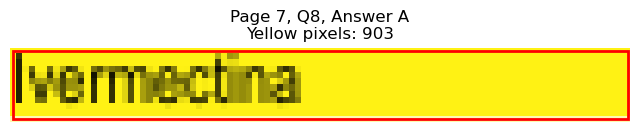

Page 7, Q8 - B: Detected box: x0=68.3, y0=659.1, x1=152.5, y1=670.2
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 439
Page 7, Q8, B: Yellow percentage: 0.0%


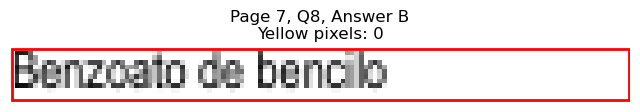

Page 7, Q8 - C: Detected box: x0=327.5, y0=646.5, x1=374.2, y1=657.6
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 235
Page 7, Q8, C: Yellow percentage: 0.0%


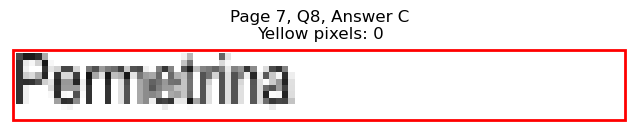

Page 7, Q8 - D: Detected box: x0=327.5, y0=659.1, x1=362.2, y1=670.2
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 139
Page 7, Q8, D: Yellow percentage: 0.0%


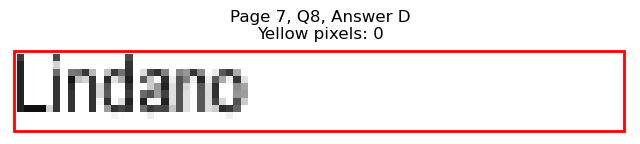


Page 7, Q8 - Selected Answer: A (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=709.6, x1=140.0, y1=720.7
Page 7, Q9, A: Yellow pixels: 123
Page 7, Q9, A: Total non-white pixels: 480
Page 7, Q9, A: Yellow percentage: 25.6%


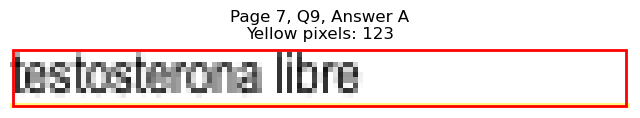

Page 7, Q9 - B: Detected box: x0=68.3, y0=722.2, x1=124.9, y1=733.3
Page 7, Q9, B: Yellow pixels: 971
Page 7, Q9, B: Total non-white pixels: 1284
Page 7, Q9, B: Yellow percentage: 75.6%


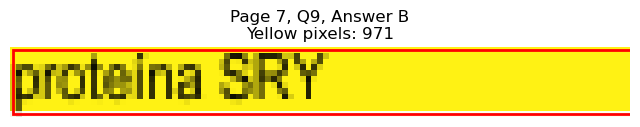

Page 7, Q9 - C: Detected box: x0=327.5, y0=709.6, x1=453.8, y1=720.7
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 680
Page 7, Q9, C: Yellow percentage: 0.0%


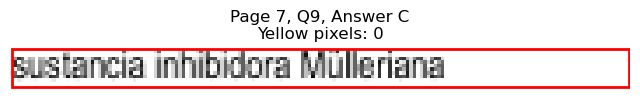

Page 7, Q9 - D: Detected box: x0=327.5, y0=722.2, x1=394.3, y1=733.3
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 362
Page 7, Q9, D: Yellow percentage: 0.0%


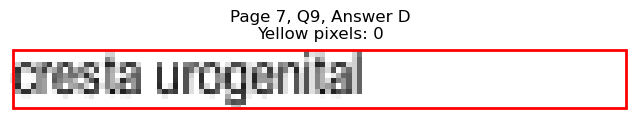


Page 7, Q9 - Selected Answer: B (based on yellow pixel count)





Page 8: Found 9 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=122.4, y1=127.4
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 277
Page 8, Q1, A: Yellow percentage: 0.0%


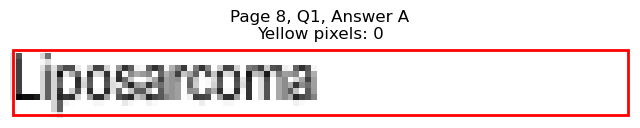

Page 8, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=115.0, y1=140.0
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 239
Page 8, Q1, B: Yellow percentage: 0.0%


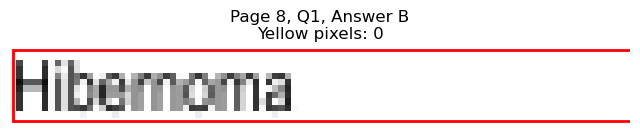

Page 8, Q1 - C: Detected box: x0=327.5, y0=116.4, x1=383.6, y1=127.4
Page 8, Q1, C: Yellow pixels: 975
Page 8, Q1, C: Total non-white pixels: 1284
Page 8, Q1, C: Yellow percentage: 75.9%


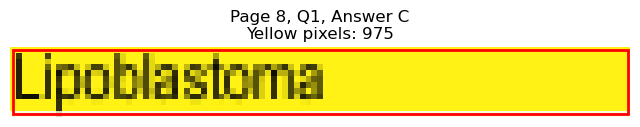

Page 8, Q1 - D: Detected box: x0=327.5, y0=129.0, x1=401.8, y1=140.0
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 347
Page 8, Q1, D: Yellow percentage: 0.0%


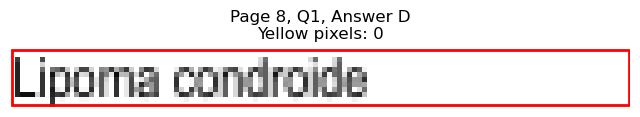


Page 8, Q1 - Selected Answer: C (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=80.9, y1=190.5
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 52
Page 8, Q2, A: Yellow percentage: 0.0%


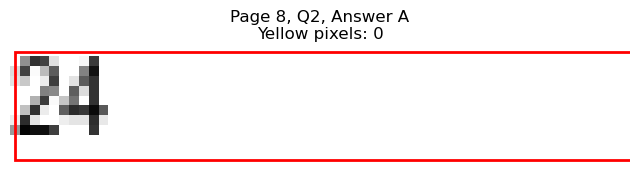

Page 8, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=80.9, y1=203.1
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 67
Page 8, Q2, B: Yellow percentage: 0.0%


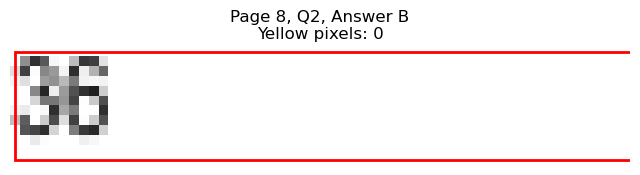

Page 8, Q2 - C: Detected box: x0=327.5, y0=179.5, x1=340.1, y1=190.5
Page 8, Q2, C: Yellow pixels: 64
Page 8, Q2, C: Total non-white pixels: 126
Page 8, Q2, C: Yellow percentage: 50.8%


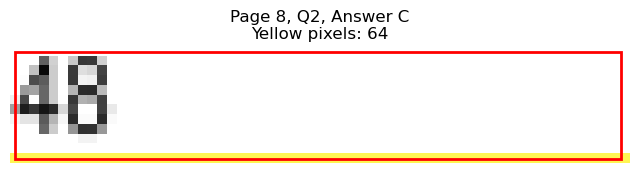

Page 8, Q2 - D: Detected box: x0=327.5, y0=192.1, x1=340.1, y1=203.1
Page 8, Q2, D: Yellow pixels: 674
Page 8, Q2, D: Total non-white pixels: 704
Page 8, Q2, D: Yellow percentage: 95.7%


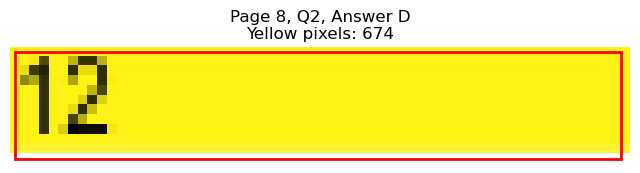


Page 8, Q2 - Selected Answer: D (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=255.2, x1=179.6, y1=266.2
Page 8, Q3, A: Yellow pixels: 1386
Page 8, Q3, A: Total non-white pixels: 1782
Page 8, Q3, A: Yellow percentage: 77.8%


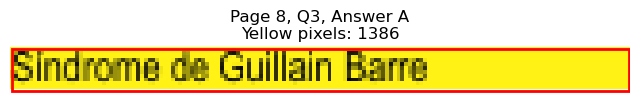

Page 8, Q3 - B: Detected box: x0=68.3, y0=267.8, x1=139.6, y1=278.8
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 390
Page 8, Q3, B: Yellow percentage: 0.0%


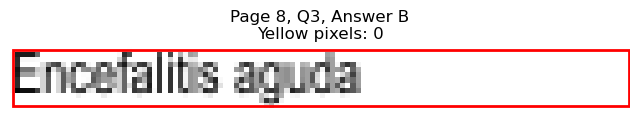

Page 8, Q3 - C: Detected box: x0=327.5, y0=255.2, x1=440.9, y1=266.2
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 596
Page 8, Q3, C: Yellow percentage: 0.0%


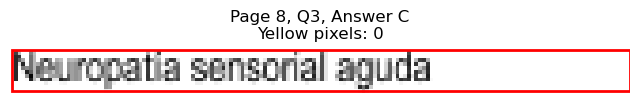

Page 8, Q3 - D: Detected box: x0=327.5, y0=267.8, x1=406.2, y1=278.8
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 390
Page 8, Q3, D: Yellow percentage: 0.0%


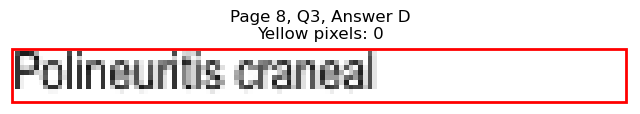


Page 8, Q3 - Selected Answer: A (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=330.9, x1=124.0, y1=342.0
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 278
Page 8, Q4, A: Yellow percentage: 0.0%


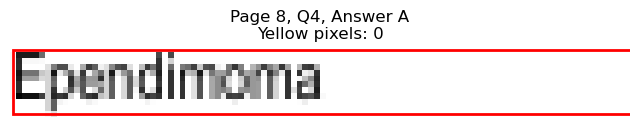

Page 8, Q4 - B: Detected box: x0=68.3, y0=343.6, x1=146.5, y1=354.7
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 394
Page 8, Q4, B: Yellow percentage: 0.0%


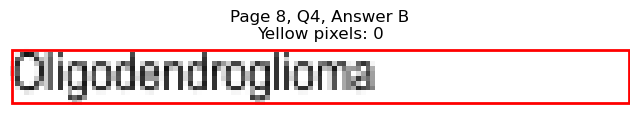

Page 8, Q4 - C: Detected box: x0=327.5, y0=330.9, x1=396.2, y1=342.0
Page 8, Q4, C: Yellow pixels: 1122
Page 8, Q4, C: Total non-white pixels: 1440
Page 8, Q4, C: Yellow percentage: 77.9%


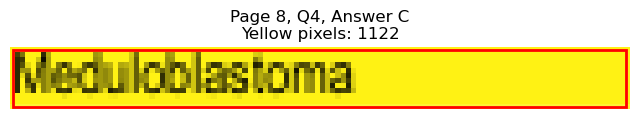

Page 8, Q4 - D: Detected box: x0=327.5, y0=343.6, x1=379.1, y1=354.7
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 285
Page 8, Q4, D: Yellow percentage: 0.0%


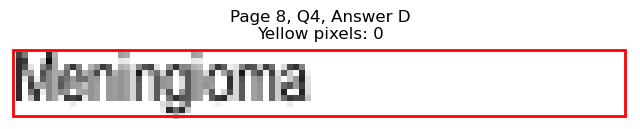


Page 8, Q4 - Selected Answer: C (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=419.4, x1=112.4, y1=430.4
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 233
Page 8, Q5, A: Yellow percentage: 0.0%


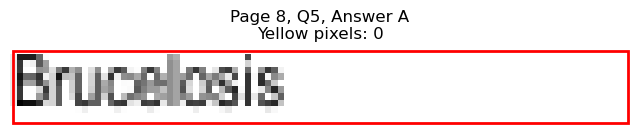

Page 8, Q5 - B: Detected box: x0=68.3, y0=432.0, x1=112.9, y1=443.0
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 225
Page 8, Q5, B: Yellow percentage: 0.0%


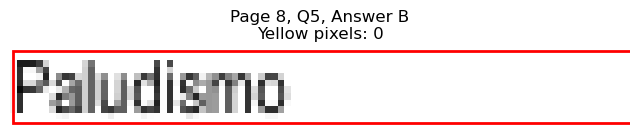

Page 8, Q5 - C: Detected box: x0=327.5, y0=419.4, x1=387.1, y1=430.4
Page 8, Q5, C: Yellow pixels: 972
Page 8, Q5, C: Total non-white pixels: 1332
Page 8, Q5, C: Yellow percentage: 73.0%


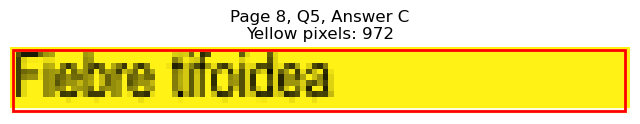

Page 8, Q5 - D: Detected box: x0=327.5, y0=432.0, x1=361.6, y1=443.0
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 182
Page 8, Q5, D: Yellow percentage: 0.0%


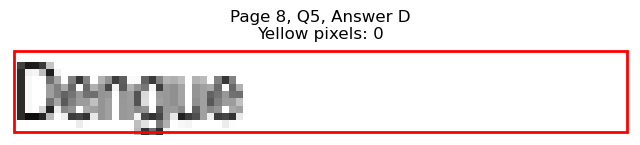


Page 8, Q5 - Selected Answer: C (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=495.1, x1=190.7, y1=506.1
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 615
Page 8, Q6, A: Yellow percentage: 0.0%


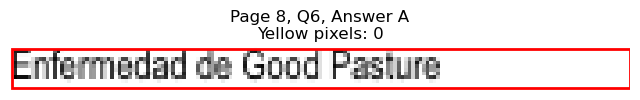

Page 8, Q6 - B: Detected box: x0=68.3, y0=507.7, x1=150.0, y1=518.7
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 401
Page 8, Q6, B: Yellow percentage: 0.0%


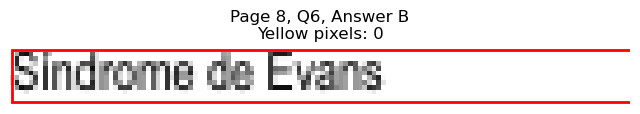

Page 8, Q6 - C: Detected box: x0=327.5, y0=495.1, x1=450.8, y1=506.1
Page 8, Q6, C: Yellow pixels: 1478
Page 8, Q6, C: Total non-white pixels: 1915
Page 8, Q6, C: Yellow percentage: 77.2%


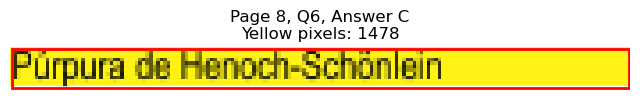

Page 8, Q6 - D: Detected box: x0=327.5, y0=507.7, x1=455.4, y1=518.7
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 692
Page 8, Q6, D: Yellow percentage: 0.0%


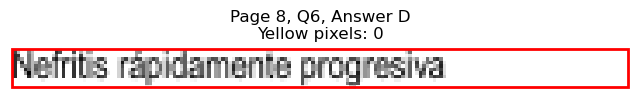


Page 8, Q6 - Selected Answer: C (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=558.2, x1=157.6, y1=569.2
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 459
Page 8, Q7, A: Yellow percentage: 0.0%


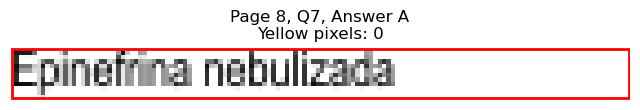

Page 8, Q7 - B: Detected box: x0=68.3, y0=570.8, x1=131.5, y1=581.8
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 329
Page 8, Q7, B: Yellow percentage: 0.0%


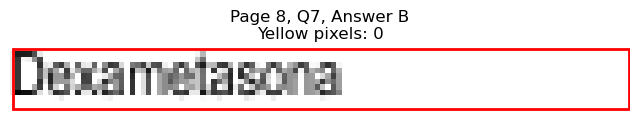

Page 8, Q7 - C: Detected box: x0=327.5, y0=558.2, x1=424.2, y1=569.2
Page 8, Q7, C: Yellow pixels: 1274
Page 8, Q7, C: Total non-white pixels: 1630
Page 8, Q7, C: Yellow percentage: 78.2%


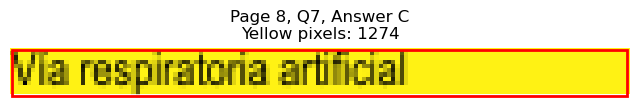

Page 8, Q7 - D: Detected box: x0=327.5, y0=570.8, x1=409.7, y1=581.8
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 413
Page 8, Q7, D: Yellow percentage: 0.0%


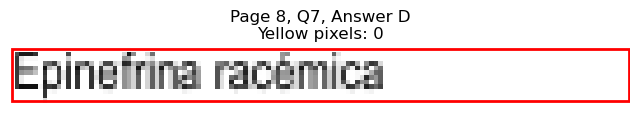


Page 8, Q7 - Selected Answer: C (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=633.9, x1=120.5, y1=645.0
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 258
Page 8, Q8, A: Yellow percentage: 0.0%


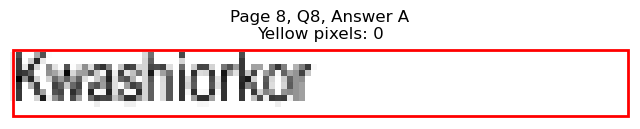

Page 8, Q8 - B: Detected box: x0=68.3, y0=646.5, x1=182.2, y1=657.6
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 544
Page 8, Q8, B: Yellow percentage: 0.0%


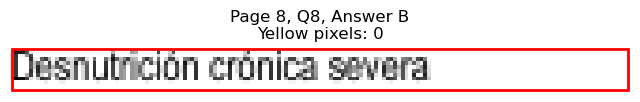

Page 8, Q8 - C: Detected box: x0=327.5, y0=633.9, x1=367.6, y1=645.0
Page 8, Q8, C: Yellow pixels: 923
Page 8, Q8, C: Total non-white pixels: 1092
Page 8, Q8, C: Yellow percentage: 84.5%


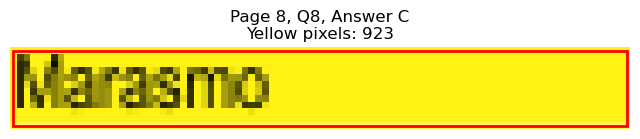

Page 8, Q8 - D: Detected box: x0=327.5, y0=646.5, x1=426.2, y1=657.6
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 485
Page 8, Q8, D: Yellow percentage: 0.0%


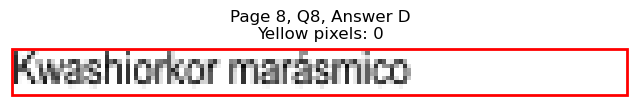


Page 8, Q8 - Selected Answer: C (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=709.6, x1=130.9, y1=720.7
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 323
Page 8, Q9, A: Yellow percentage: 0.0%


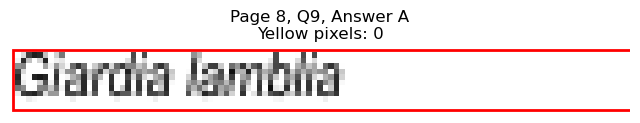

Page 8, Q9 - B: Detected box: x0=68.3, y0=722.2, x1=136.4, y1=733.3
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 323
Page 8, Q9, B: Yellow percentage: 0.0%


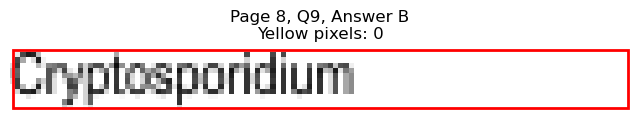

Page 8, Q9 - C: Detected box: x0=327.5, y0=709.6, x1=393.1, y1=720.7
Page 8, Q9, C: Yellow pixels: 1138
Page 8, Q9, C: Total non-white pixels: 1404
Page 8, Q9, C: Yellow percentage: 81.1%


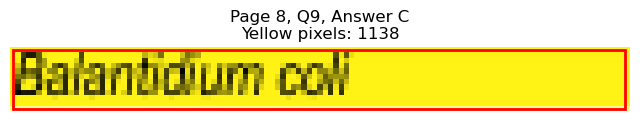

Page 8, Q9 - D: Detected box: x0=327.5, y0=722.2, x1=372.7, y1=733.3
Page 8, Q9, D: Yellow pixels: 0
Page 8, Q9, D: Total non-white pixels: 244
Page 8, Q9, D: Yellow percentage: 0.0%


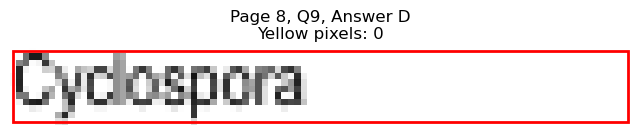


Page 8, Q9 - Selected Answer: C (based on yellow pixel count)





Page 9: Found 9 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=178.6, y1=114.8
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 565
Page 9, Q1, A: Yellow percentage: 0.0%


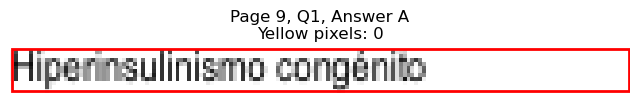

Page 9, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=204.1, y1=127.4
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 727
Page 9, Q1, B: Yellow percentage: 0.0%


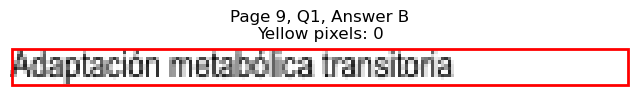

Page 9, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=477.8, y1=114.8
Page 9, Q1, C: Yellow pixels: 1814
Page 9, Q1, C: Total non-white pixels: 2412
Page 9, Q1, C: Yellow percentage: 75.2%


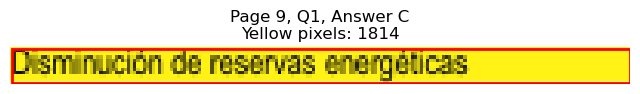

Page 9, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=393.7, y1=127.4
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 355
Page 9, Q1, D: Yellow percentage: 0.0%


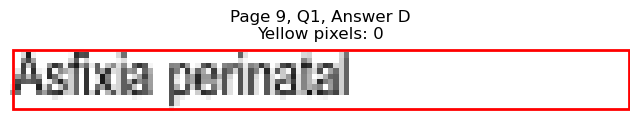


Page 9, Q1 - Selected Answer: C (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=119.9, y1=190.5
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 267
Page 9, Q2, A: Yellow percentage: 0.0%


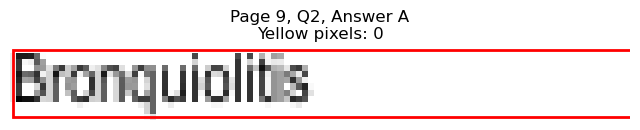

Page 9, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=133.4, y1=203.1
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 338
Page 9, Q2, B: Yellow percentage: 0.0%


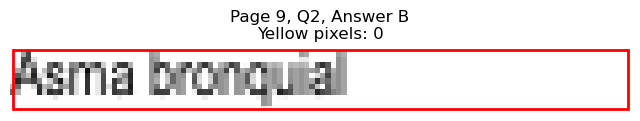

Page 9, Q2 - C: Detected box: x0=327.5, y0=179.5, x1=429.8, y1=190.5
Page 9, Q2, C: Yellow pixels: 153
Page 9, Q2, C: Total non-white pixels: 689
Page 9, Q2, C: Yellow percentage: 22.2%


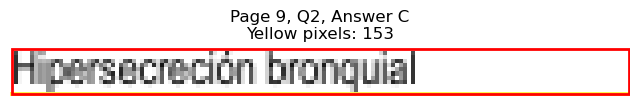

Page 9, Q2 - D: Detected box: x0=327.5, y0=192.1, x1=434.8, y1=203.1
Page 9, Q2, D: Yellow pixels: 1294
Page 9, Q2, D: Total non-white pixels: 1742
Page 9, Q2, D: Yellow percentage: 74.3%


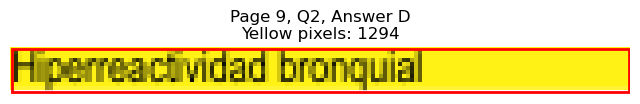


Page 9, Q2 - Selected Answer: D (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=267.8, x1=168.1, y1=278.8
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 527
Page 9, Q3, A: Yellow percentage: 0.0%


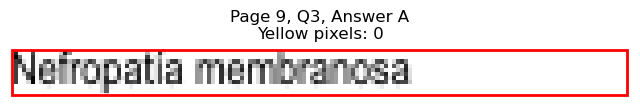

Page 9, Q3 - B: Detected box: x0=68.3, y0=280.5, x1=233.3, y1=291.6
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 866
Page 9, Q3, B: Yellow percentage: 0.0%


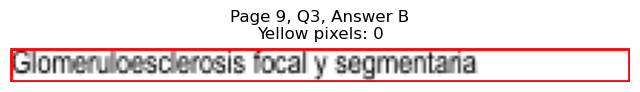

Page 9, Q3 - C: Detected box: x0=327.5, y0=267.8, x1=464.4, y1=278.8
Page 9, Q3, C: Yellow pixels: 1746
Page 9, Q3, C: Total non-white pixels: 2256
Page 9, Q3, C: Yellow percentage: 77.4%


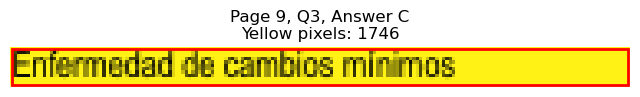

Page 9, Q3 - D: Detected box: x0=327.5, y0=280.5, x1=384.1, y1=291.6
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 306
Page 9, Q3, D: Yellow percentage: 0.0%


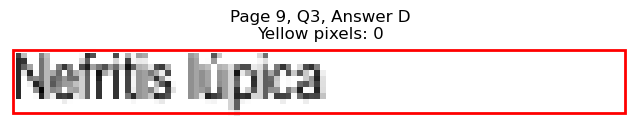


Page 9, Q3 - Selected Answer: C (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=343.6, x1=245.4, y1=354.7
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 917
Page 9, Q4, A: Yellow percentage: 0.0%


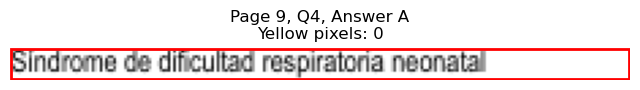

Page 9, Q4 - B: Detected box: x0=68.3, y0=356.2, x1=215.3, y1=367.3
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 733
Page 9, Q4, B: Yellow percentage: 0.0%


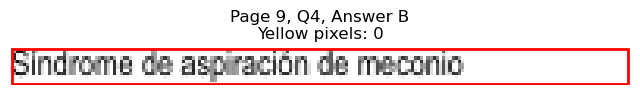

Page 9, Q4 - C: Detected box: x0=327.5, y0=343.6, x1=485.4, y1=354.7
Page 9, Q4, C: Yellow pixels: 1911
Page 9, Q4, C: Total non-white pixels: 2508
Page 9, Q4, C: Yellow percentage: 76.2%


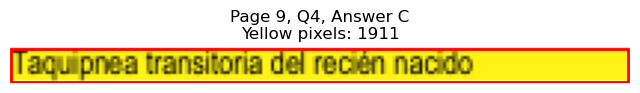

Page 9, Q4 - D: Detected box: x0=327.5, y0=356.2, x1=511.1, y1=367.3
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 914
Page 9, Q4, D: Yellow percentage: 0.0%


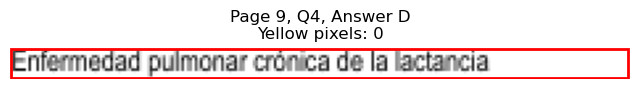


Page 9, Q4 - Selected Answer: C (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=419.4, x1=121.4, y1=430.4
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 247
Page 9, Q5, A: Yellow percentage: 0.0%


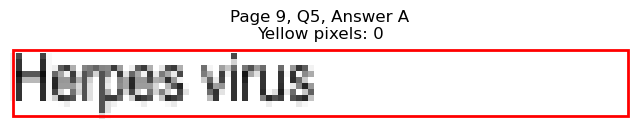

Page 9, Q5 - B: Detected box: x0=68.3, y0=432.0, x1=147.0, y1=443.0
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 375
Page 9, Q5, B: Yellow percentage: 0.0%


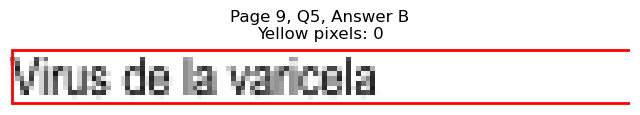

Page 9, Q5 - C: Detected box: x0=327.5, y0=419.4, x1=393.1, y1=430.4
Page 9, Q5, C: Yellow pixels: 1049
Page 9, Q5, C: Total non-white pixels: 1404
Page 9, Q5, C: Yellow percentage: 74.7%


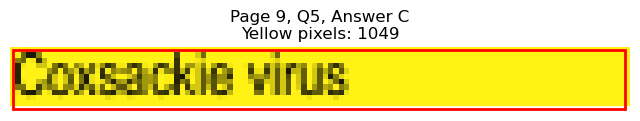

Page 9, Q5 - D: Detected box: x0=327.5, y0=432.0, x1=391.2, y1=443.0
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 305
Page 9, Q5, D: Yellow percentage: 0.0%


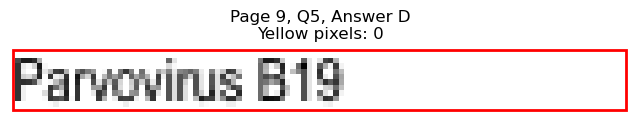


Page 9, Q5 - Selected Answer: C (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=507.7, x1=152.0, y1=518.7
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 433
Page 9, Q6, A: Yellow percentage: 0.0%


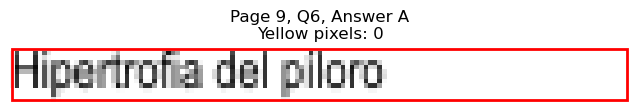

Page 9, Q6 - B: Detected box: x0=68.3, y0=520.3, x1=135.5, y1=531.3
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 323
Page 9, Q6, B: Yellow percentage: 0.0%


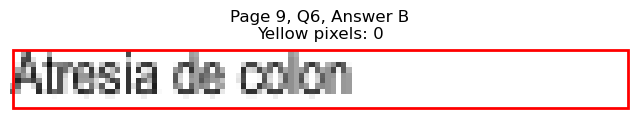

Page 9, Q6 - C: Detected box: x0=327.5, y0=507.7, x1=393.7, y1=518.7
Page 9, Q6, C: Yellow pixels: 117
Page 9, Q6, C: Total non-white pixels: 450
Page 9, Q6, C: Yellow percentage: 26.0%


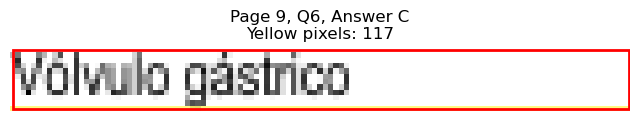

Page 9, Q6 - D: Detected box: x0=327.5, y0=520.3, x1=391.7, y1=531.3
Page 9, Q6, D: Yellow pixels: 1014
Page 9, Q6, D: Total non-white pixels: 1380
Page 9, Q6, D: Yellow percentage: 73.5%


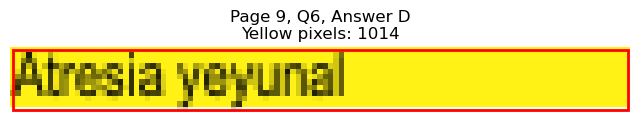


Page 9, Q6 - Selected Answer: D (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=570.8, x1=80.9, y1=581.8
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 109
Page 9, Q7, A: Yellow percentage: 0.0%


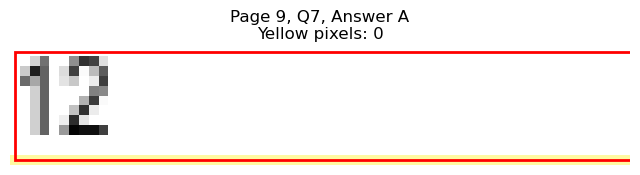

Page 9, Q7 - B: Detected box: x0=68.3, y0=583.4, x1=80.9, y1=594.4
Page 9, Q7, B: Yellow pixels: 650
Page 9, Q7, B: Total non-white pixels: 756
Page 9, Q7, B: Yellow percentage: 86.0%


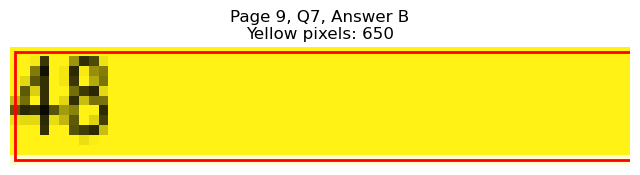

Page 9, Q7 - C: Detected box: x0=327.5, y0=570.8, x1=340.1, y1=581.8
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 55
Page 9, Q7, C: Yellow percentage: 0.0%


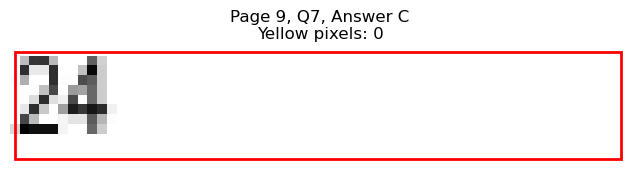

Page 9, Q7 - D: Detected box: x0=327.5, y0=583.4, x1=340.1, y1=594.4
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 66
Page 9, Q7, D: Yellow percentage: 0.0%


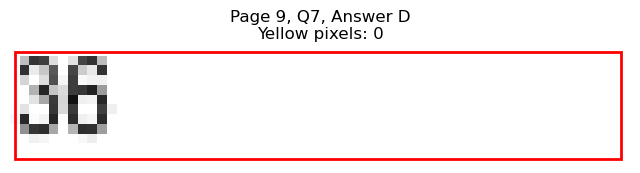


Page 9, Q7 - Selected Answer: B (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=646.5, x1=219.1, y1=657.6
Page 9, Q8, A: Yellow pixels: 1664
Page 9, Q8, A: Total non-white pixels: 2424
Page 9, Q8, A: Yellow percentage: 68.6%


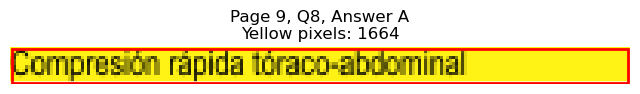

Page 9, Q8 - B: Detected box: x0=68.3, y0=659.1, x1=121.9, y1=670.2
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 290
Page 9, Q8, B: Yellow percentage: 0.0%


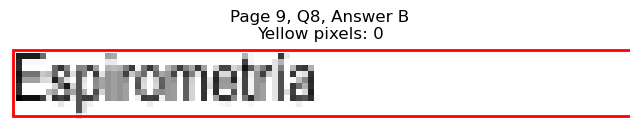

Page 9, Q8 - C: Detected box: x0=327.5, y0=646.5, x1=387.7, y1=657.6
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 326
Page 9, Q8, C: Yellow percentage: 0.0%


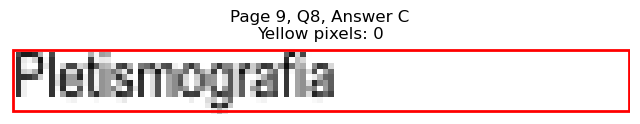

Page 9, Q8 - D: Detected box: x0=327.5, y0=659.1, x1=431.3, y1=670.2
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 517
Page 9, Q8, D: Yellow percentage: 0.0%


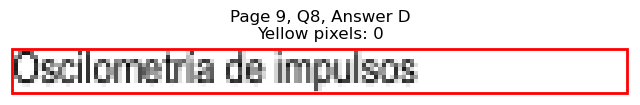


Page 9, Q8 - Selected Answer: A (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=722.2, x1=195.7, y1=733.3
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 669
Page 9, Q9, A: Yellow percentage: 0.0%


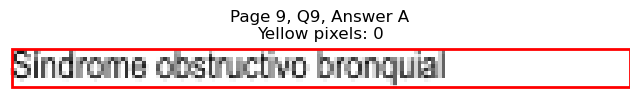

Page 9, Q9 - B: Detected box: x0=68.3, y0=734.8, x1=164.5, y1=745.9
Page 9, Q9, B: Yellow pixels: 0
Page 9, Q9, B: Total non-white pixels: 514
Page 9, Q9, B: Yellow percentage: 0.0%


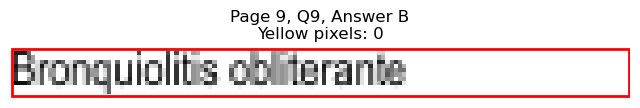

Page 9, Q9 - C: Detected box: x0=327.5, y0=722.2, x1=437.8, y1=733.3
Page 9, Q9, C: Yellow pixels: 161
Page 9, Q9, C: Total non-white pixels: 748
Page 9, Q9, C: Yellow percentage: 21.5%


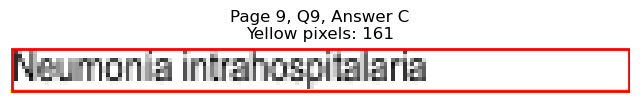

Page 9, Q9 - D: Detected box: x0=327.5, y0=734.8, x1=431.9, y1=745.9
Page 9, Q9, D: Yellow pixels: 1446
Page 9, Q9, D: Total non-white pixels: 1860
Page 9, Q9, D: Yellow percentage: 77.7%


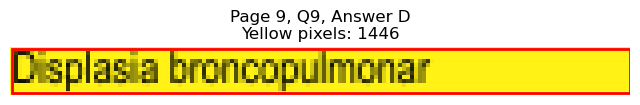


Page 9, Q9 - Selected Answer: D (based on yellow pixel count)





Page 10: Found 9 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=129.0, x1=119.9, y1=140.0
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 265
Page 10, Q1, A: Yellow percentage: 0.0%


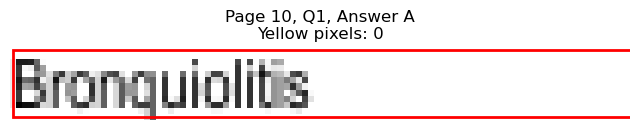

Page 10, Q1 - B: Detected box: x0=68.3, y0=141.7, x1=112.4, y1=152.7
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 221
Page 10, Q1, B: Yellow percentage: 0.0%


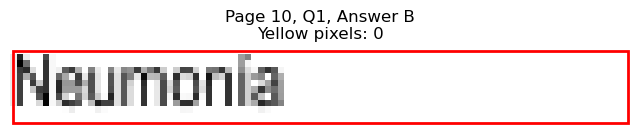

Page 10, Q1 - C: Detected box: x0=327.5, y0=129.0, x1=355.1, y1=140.0
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 217
Page 10, Q1, C: Yellow percentage: 0.0%


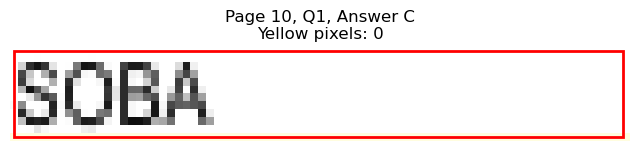

Page 10, Q1 - D: Detected box: x0=327.5, y0=141.7, x1=370.1, y1=152.7
Page 10, Q1, D: Yellow pixels: 985
Page 10, Q1, D: Total non-white pixels: 1128
Page 10, Q1, D: Yellow percentage: 87.3%


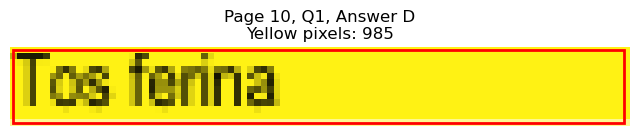


Page 10, Q1 - Selected Answer: D (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=103.4, y1=190.5
Page 10, Q2, A: Yellow pixels: 785
Page 10, Q2, A: Total non-white pixels: 1032
Page 10, Q2, A: Yellow percentage: 76.1%


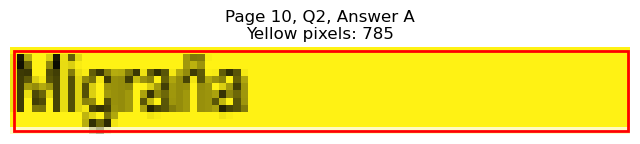

Page 10, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=133.9, y1=203.1
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 347
Page 10, Q2, B: Yellow percentage: 0.0%


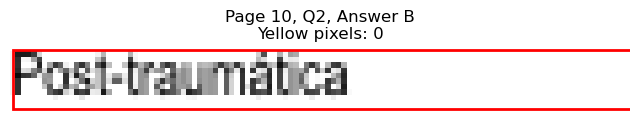

Page 10, Q2 - C: Detected box: x0=327.5, y0=179.5, x1=423.2, y1=190.5
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 472
Page 10, Q2, C: Yellow percentage: 0.0%


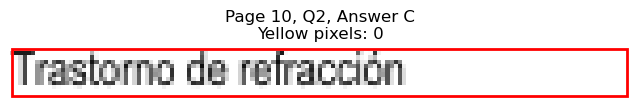

Page 10, Q2 - D: Detected box: x0=327.5, y0=192.1, x1=363.6, y1=203.1
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 162
Page 10, Q2, D: Yellow percentage: 0.0%


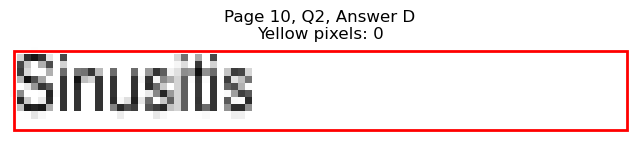


Page 10, Q2 - Selected Answer: A (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=68.3, y0=242.6, x1=136.4, y1=253.6
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 321
Page 10, Q3, A: Yellow percentage: 0.0%


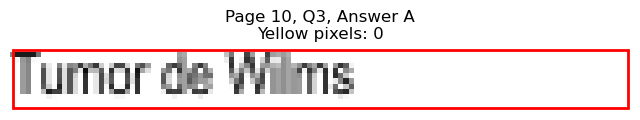

Page 10, Q3 - B: Detected box: x0=68.3, y0=255.2, x1=160.1, y1=266.2
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 455
Page 10, Q3, B: Yellow percentage: 0.0%


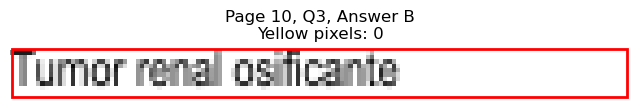

Page 10, Q3 - C: Detected box: x0=327.5, y0=242.6, x1=435.8, y1=253.6
Page 10, Q3, C: Yellow pixels: 159
Page 10, Q3, C: Total non-white pixels: 701
Page 10, Q3, C: Yellow percentage: 22.7%


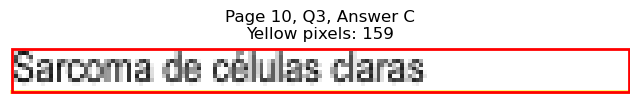

Page 10, Q3 - D: Detected box: x0=327.5, y0=255.2, x1=461.3, y1=266.2
Page 10, Q3, D: Yellow pixels: 1524
Page 10, Q3, D: Total non-white pixels: 2038
Page 10, Q3, D: Yellow percentage: 74.8%


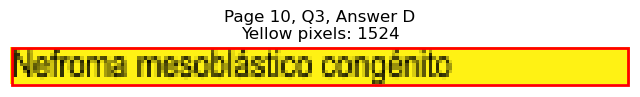


Page 10, Q3 - Selected Answer: D (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=68.3, y0=305.7, x1=221.3, y1=316.8
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 766
Page 10, Q4, A: Yellow percentage: 0.0%


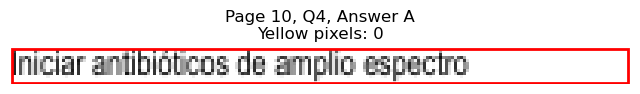

Page 10, Q4 - B: Detected box: x0=68.3, y0=318.3, x1=133.9, y1=329.4
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 312
Page 10, Q4, B: Yellow percentage: 0.0%


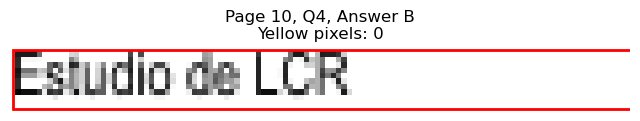

Page 10, Q4 - C: Detected box: x0=327.5, y0=305.7, x1=453.8, y1=316.8
Page 10, Q4, C: Yellow pixels: 1639
Page 10, Q4, C: Total non-white pixels: 2124
Page 10, Q4, C: Yellow percentage: 77.2%


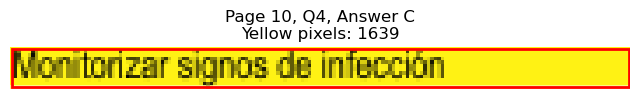

Page 10, Q4 - D: Detected box: x0=327.5, y0=318.3, x1=426.7, y1=329.4
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 517
Page 10, Q4, D: Yellow percentage: 0.0%


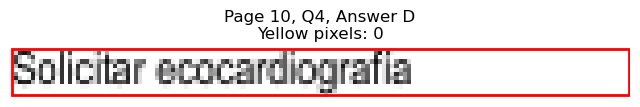


Page 10, Q4 - Selected Answer: C (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=68.3, y0=381.4, x1=146.5, y1=392.5
Page 10, Q5, A: Yellow pixels: 129
Page 10, Q5, A: Total non-white pixels: 535
Page 10, Q5, A: Yellow percentage: 24.1%


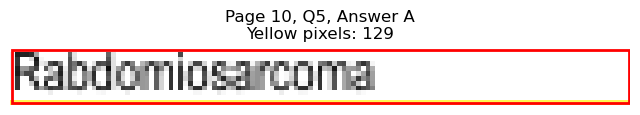

Page 10, Q5 - B: Detected box: x0=68.3, y0=394.0, x1=113.9, y1=405.1
Page 10, Q5, B: Yellow pixels: 873
Page 10, Q5, B: Total non-white pixels: 1056
Page 10, Q5, B: Yellow percentage: 82.7%


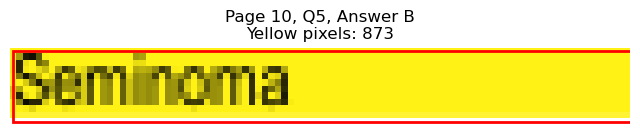

Page 10, Q5 - C: Detected box: x0=327.5, y0=381.4, x1=368.6, y1=392.5
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 204
Page 10, Q5, C: Yellow percentage: 0.0%


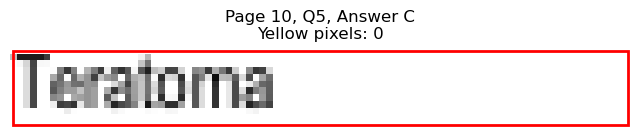

Page 10, Q5 - D: Detected box: x0=327.5, y0=394.0, x1=408.2, y1=405.1
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 423
Page 10, Q5, D: Yellow percentage: 0.0%


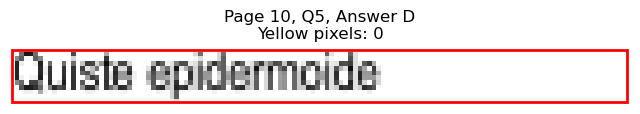


Page 10, Q5 - Selected Answer: B (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=68.3, y0=457.2, x1=130.4, y1=468.2
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 328
Page 10, Q6, A: Yellow percentage: 0.0%


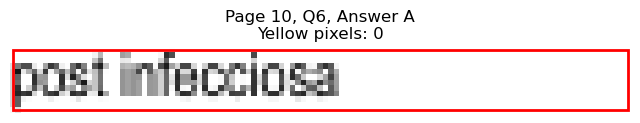

Page 10, Q6 - B: Detected box: x0=68.3, y0=469.8, x1=165.6, y1=480.8
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 522
Page 10, Q6, B: Yellow percentage: 0.0%


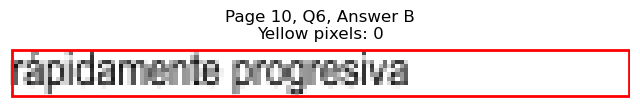

Page 10, Q6 - C: Detected box: x0=327.5, y0=457.2, x1=425.8, y1=468.2
Page 10, Q6, C: Yellow pixels: 149
Page 10, Q6, C: Total non-white pixels: 790
Page 10, Q6, C: Yellow percentage: 18.9%


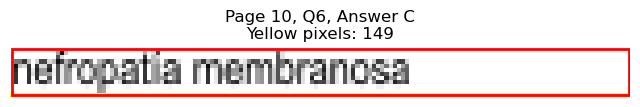

Page 10, Q6 - D: Detected box: x0=327.5, y0=469.8, x1=422.3, y1=480.8
Page 10, Q6, D: Yellow pixels: 1389
Page 10, Q6, D: Total non-white pixels: 1752
Page 10, Q6, D: Yellow percentage: 79.3%


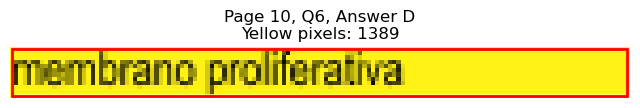


Page 10, Q6 - Selected Answer: D (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=68.3, y0=532.9, x1=149.0, y1=543.9
Page 10, Q7, A: Yellow pixels: 1289
Page 10, Q7, A: Total non-white pixels: 1584
Page 10, Q7, A: Yellow percentage: 81.4%


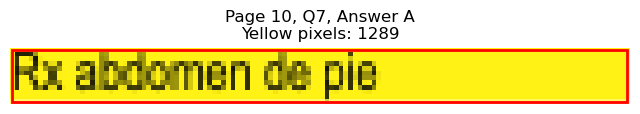

Page 10, Q7 - B: Detected box: x0=68.3, y0=545.5, x1=187.7, y1=556.5
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 664
Page 10, Q7, B: Yellow percentage: 0.0%


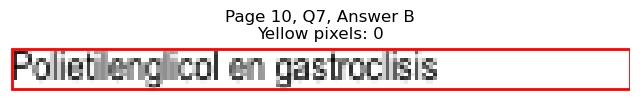

Page 10, Q7 - C: Detected box: x0=327.5, y0=532.9, x1=411.7, y1=543.9
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 406
Page 10, Q7, C: Yellow percentage: 0.0%


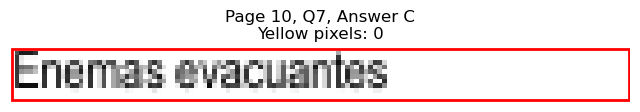

Page 10, Q7 - D: Detected box: x0=327.5, y0=545.5, x1=421.8, y1=556.5
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 486
Page 10, Q7, D: Yellow percentage: 0.0%


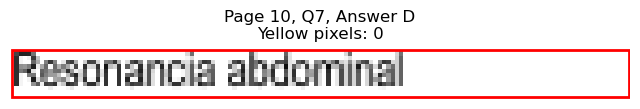


Page 10, Q7 - Selected Answer: A (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=68.3, y0=596.0, x1=109.4, y1=607.0
Page 10, Q8, A: Yellow pixels: 0
Page 10, Q8, A: Total non-white pixels: 228
Page 10, Q8, A: Yellow percentage: 0.0%


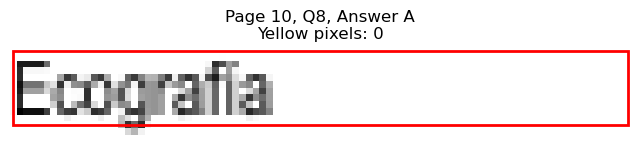

Page 10, Q8 - B: Detected box: x0=68.3, y0=608.6, x1=116.9, y1=619.6
Page 10, Q8, B: Yellow pixels: 0
Page 10, Q8, B: Total non-white pixels: 237
Page 10, Q8, B: Yellow percentage: 0.0%


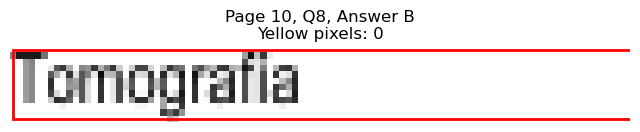

Page 10, Q8 - C: Detected box: x0=327.5, y0=596.0, x1=376.7, y1=607.0
Page 10, Q8, C: Yellow pixels: 983
Page 10, Q8, C: Total non-white pixels: 1203
Page 10, Q8, C: Yellow percentage: 81.7%


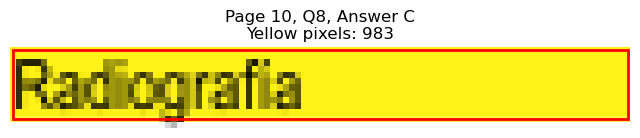

Page 10, Q8 - D: Detected box: x0=327.5, y0=545.5, x1=377.8, y1=556.5
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 486
Page 10, Q8, D: Yellow percentage: 0.0%


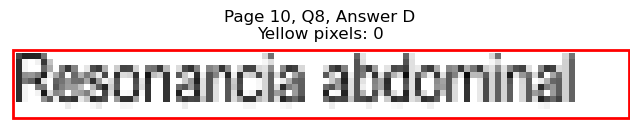


Page 10, Q8 - Selected Answer: C (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=68.3, y0=671.7, x1=249.8, y1=682.8
Page 10, Q9, A: Yellow pixels: 0
Page 10, Q9, A: Total non-white pixels: 930
Page 10, Q9, A: Yellow percentage: 0.0%


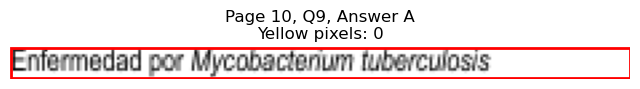

Page 10, Q9 - B: Detected box: x0=68.3, y0=684.3, x1=236.3, y1=695.4
Page 10, Q9, B: Yellow pixels: 0
Page 10, Q9, B: Total non-white pixels: 867
Page 10, Q9, B: Yellow percentage: 0.0%


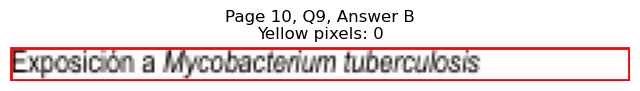

Page 10, Q9 - C: Detected box: x0=327.5, y0=671.7, x1=496.0, y1=682.8
Page 10, Q9, C: Yellow pixels: 1900
Page 10, Q9, C: Total non-white pixels: 2556
Page 10, Q9, C: Yellow percentage: 74.3%


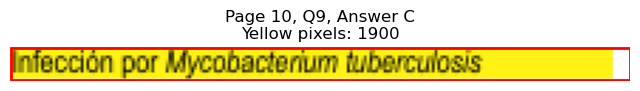

Page 10, Q9 - D: Detected box: x0=327.5, y0=684.3, x1=431.8, y1=695.4
Page 10, Q9, D: Yellow pixels: 0
Page 10, Q9, D: Total non-white pixels: 520
Page 10, Q9, D: Yellow percentage: 0.0%


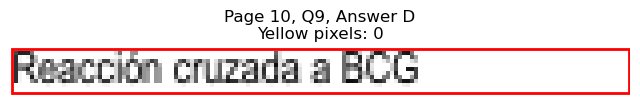


Page 10, Q9 - Selected Answer: C (based on yellow pixel count)





Page 11: Found 9 questions
Page 11, Q1 - A: Detected box: x0=68.3, y0=129.0, x1=118.0, y1=140.0
Page 11, Q1, A: Yellow pixels: 0
Page 11, Q1, A: Total non-white pixels: 344
Page 11, Q1, A: Yellow percentage: 0.0%


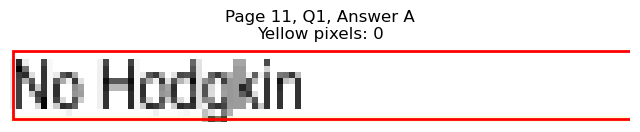

Page 11, Q1 - B: Detected box: x0=68.3, y0=141.7, x1=103.9, y1=152.7
Page 11, Q1, B: Yellow pixels: 901
Page 11, Q1, B: Total non-white pixels: 1032
Page 11, Q1, B: Yellow percentage: 87.3%


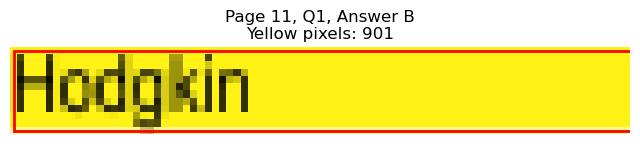

Page 11, Q1 - C: Detected box: x0=327.5, y0=129.0, x1=380.2, y1=140.0
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 266
Page 11, Q1, C: Yellow percentage: 0.0%


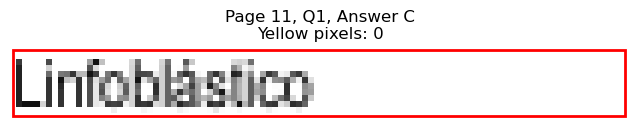

Page 11, Q1 - D: Detected box: x0=327.5, y0=141.7, x1=403.7, y1=152.7
Page 11, Q1, D: Yellow pixels: 0
Page 11, Q1, D: Total non-white pixels: 405
Page 11, Q1, D: Yellow percentage: 0.0%


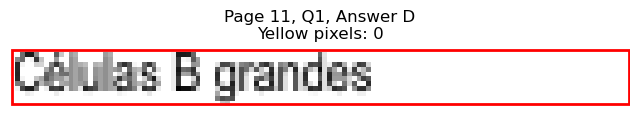


Page 11, Q1 - Selected Answer: B (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=68.3, y0=217.4, x1=146.5, y1=228.4
Page 11, Q2, A: Yellow pixels: 0
Page 11, Q2, A: Total non-white pixels: 396
Page 11, Q2, A: Yellow percentage: 0.0%


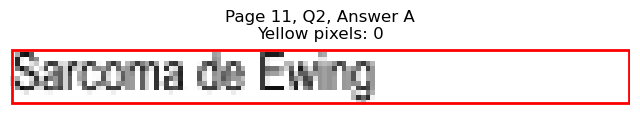

Page 11, Q2 - B: Detected box: x0=68.3, y0=230.0, x1=146.5, y1=241.0
Page 11, Q2, B: Yellow pixels: 0
Page 11, Q2, B: Total non-white pixels: 406
Page 11, Q2, B: Yellow percentage: 0.0%


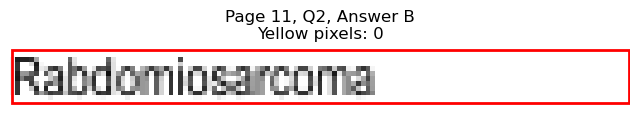

Page 11, Q2 - C: Detected box: x0=327.5, y0=217.4, x1=388.7, y1=228.4
Page 11, Q2, C: Yellow pixels: 1000
Page 11, Q2, C: Total non-white pixels: 1344
Page 11, Q2, C: Yellow percentage: 74.4%


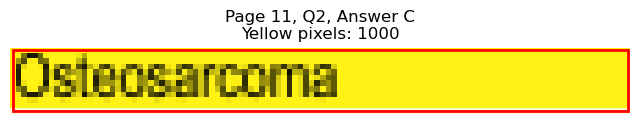

Page 11, Q2 - D: Detected box: x0=327.5, y0=230.0, x1=381.6, y1=241.0
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 294
Page 11, Q2, D: Yellow percentage: 0.0%


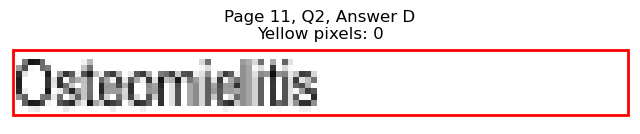


Page 11, Q2 - Selected Answer: C (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=68.3, y0=293.1, x1=110.4, y1=304.2
Page 11, Q3, A: Yellow pixels: 93
Page 11, Q3, A: Total non-white pixels: 412
Page 11, Q3, A: Yellow percentage: 22.6%


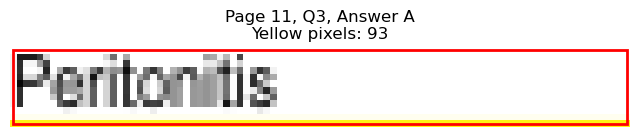

Page 11, Q3 - B: Detected box: x0=68.3, y0=305.7, x1=103.4, y1=316.8
Page 11, Q3, B: Yellow pixels: 881
Page 11, Q3, B: Total non-white pixels: 1032
Page 11, Q3, B: Yellow percentage: 85.4%


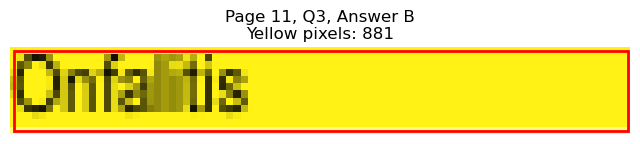

Page 11, Q3 - C: Detected box: x0=327.5, y0=293.1, x1=373.1, y1=304.2
Page 11, Q3, C: Yellow pixels: 0
Page 11, Q3, C: Total non-white pixels: 233
Page 11, Q3, C: Yellow percentage: 0.0%


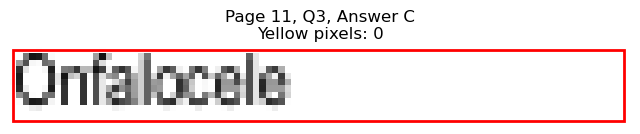

Page 11, Q3 - D: Detected box: x0=327.5, y0=305.7, x1=361.6, y1=316.8
Page 11, Q3, D: Yellow pixels: 0
Page 11, Q3, D: Total non-white pixels: 188
Page 11, Q3, D: Yellow percentage: 0.0%


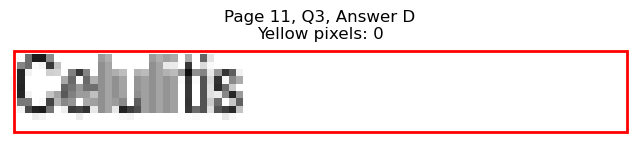


Page 11, Q3 - Selected Answer: B (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=68.3, y0=368.8, x1=240.1, y1=379.9
Page 11, Q4, A: Yellow pixels: 0
Page 11, Q4, A: Total non-white pixels: 816
Page 11, Q4, A: Yellow percentage: 0.0%


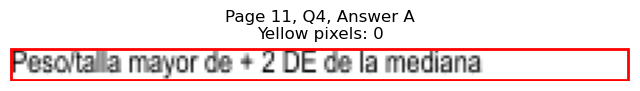

Page 11, Q4 - B: Detected box: x0=68.3, y0=381.4, x1=269.6, y1=392.5
Page 11, Q4, B: Yellow pixels: 0
Page 11, Q4, B: Total non-white pixels: 940
Page 11, Q4, B: Yellow percentage: 0.0%


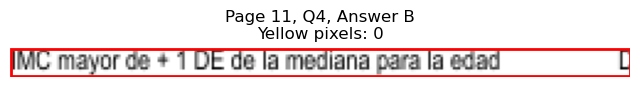

Page 11, Q4 - C: Detected box: x0=327.5, y0=368.8, x1=528.8, y1=379.9
Page 11, Q4, C: Yellow pixels: 1844
Page 11, Q4, C: Total non-white pixels: 2556
Page 11, Q4, C: Yellow percentage: 72.1%


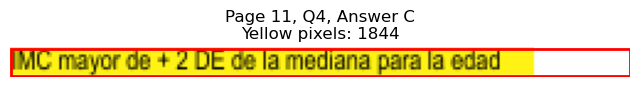

Page 11, Q4 - D: Detected box: x0=327.5, y0=381.4, x1=499.3, y1=392.5
Page 11, Q4, D: Yellow pixels: 0
Page 11, Q4, D: Total non-white pixels: 817
Page 11, Q4, D: Yellow percentage: 0.0%


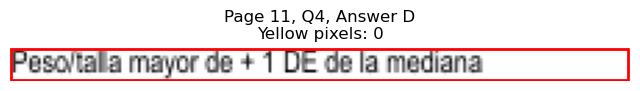


Page 11, Q4 - Selected Answer: C (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=68.3, y0=444.6, x1=97.9, y1=455.6
Page 11, Q5, A: Yellow pixels: 80
Page 11, Q5, A: Total non-white pixels: 233
Page 11, Q5, A: Yellow percentage: 34.3%


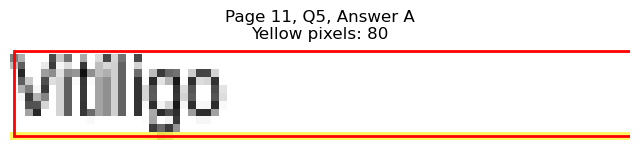

Page 11, Q5 - B: Detected box: x0=68.3, y0=457.2, x1=124.0, y1=468.2
Page 11, Q5, B: Yellow pixels: 959
Page 11, Q5, B: Total non-white pixels: 1166
Page 11, Q5, B: Yellow percentage: 82.2%


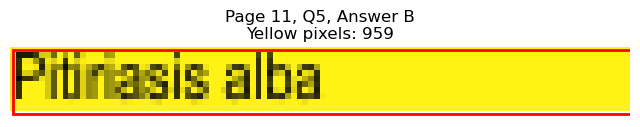

Page 11, Q5 - C: Detected box: x0=327.5, y0=444.6, x1=415.2, y1=455.6
Page 11, Q5, C: Yellow pixels: 0
Page 11, Q5, C: Total non-white pixels: 458
Page 11, Q5, C: Yellow percentage: 0.0%


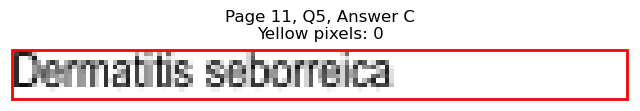

Page 11, Q5 - D: Detected box: x0=327.5, y0=457.2, x1=388.7, y1=468.2
Page 11, Q5, D: Yellow pixels: 0
Page 11, Q5, D: Total non-white pixels: 308
Page 11, Q5, D: Yellow percentage: 0.0%


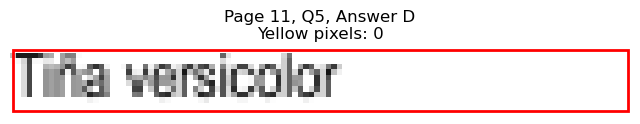


Page 11, Q5 - Selected Answer: B (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=68.3, y0=532.9, x1=115.4, y1=543.9
Page 11, Q6, A: Yellow pixels: 0
Page 11, Q6, A: Total non-white pixels: 258
Page 11, Q6, A: Yellow percentage: 0.0%


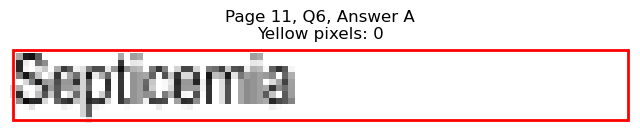

Page 11, Q6 - B: Detected box: x0=68.3, y0=545.5, x1=122.5, y1=556.5
Page 11, Q6, B: Yellow pixels: 0
Page 11, Q6, B: Total non-white pixels: 292
Page 11, Q6, B: Yellow percentage: 0.0%


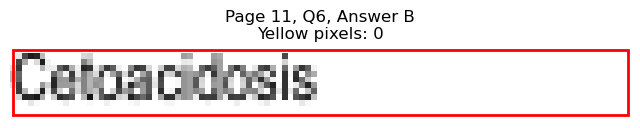

Page 11, Q6 - C: Detected box: x0=327.5, y0=532.9, x1=386.2, y1=543.9
Page 11, Q6, C: Yellow pixels: 0
Page 11, Q6, C: Total non-white pixels: 410
Page 11, Q6, C: Yellow percentage: 0.0%


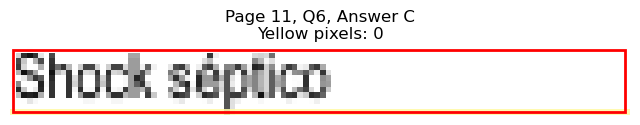

Page 11, Q6 - D: Detected box: x0=327.5, y0=545.5, x1=412.7, y1=556.5
Page 11, Q6, D: Yellow pixels: 1169
Page 11, Q6, D: Total non-white pixels: 1632
Page 11, Q6, D: Yellow percentage: 71.6%


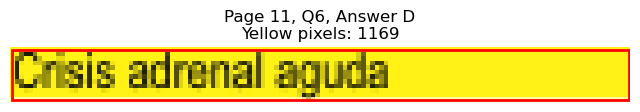


Page 11, Q6 - Selected Answer: D (based on yellow pixel count)




Page 11, Q7 - A: Detected box: x0=68.3, y0=583.4, x1=402.5, y1=594.4
Page 11, Q7, A: Yellow pixels: 385
Page 11, Q7, A: Total non-white pixels: 2016
Page 11, Q7, A: Yellow percentage: 19.1%


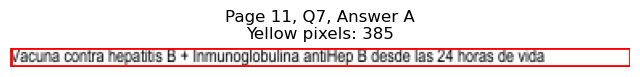

Page 11, Q7 - B: Detected box: x0=68.3, y0=596.0, x1=406.1, y1=607.0
Page 11, Q7, B: Yellow pixels: 3418
Page 11, Q7, B: Total non-white pixels: 4675
Page 11, Q7, B: Yellow percentage: 73.1%


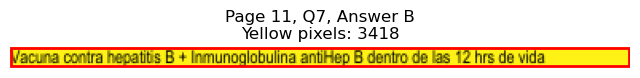

Page 11, Q7 - C: Detected box: x0=68.8, y0=608.6, x1=227.2, y1=619.6
Page 11, Q7, C: Yellow pixels: 0
Page 11, Q7, C: Total non-white pixels: 797
Page 11, Q7, C: Yellow percentage: 0.0%


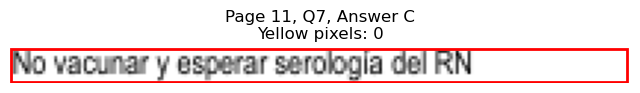

Page 11, Q7 - D: Detected box: x0=68.8, y0=621.3, x1=197.6, y1=632.4
Page 11, Q7, D: Yellow pixels: 0
Page 11, Q7, D: Total non-white pixels: 651
Page 11, Q7, D: Yellow percentage: 0.0%


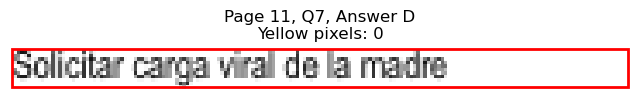


Page 11, Q7 - Selected Answer: B (based on yellow pixel count)




Page 11, Q8 - A: Detected box: x0=68.3, y0=659.1, x1=189.1, y1=670.2
Page 11, Q8, A: Yellow pixels: 1439
Page 11, Q8, A: Total non-white pixels: 1894
Page 11, Q8, A: Yellow percentage: 76.0%


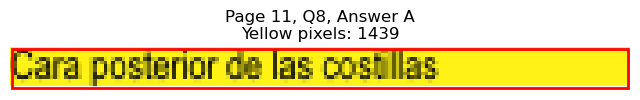

Page 11, Q8 - B: Detected box: x0=68.3, y0=671.7, x1=133.9, y1=682.8
Page 11, Q8, B: Yellow pixels: 0
Page 11, Q8, B: Total non-white pixels: 333
Page 11, Q8, B: Yellow percentage: 0.0%


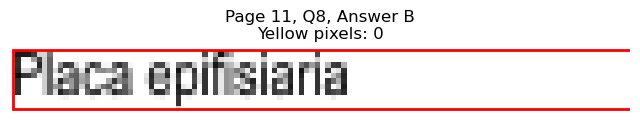

Page 11, Q8 - C: Detected box: x0=327.5, y0=659.1, x1=398.6, y1=670.2
Page 11, Q8, C: Yellow pixels: 0
Page 11, Q8, C: Total non-white pixels: 355
Page 11, Q8, C: Yellow percentage: 0.0%


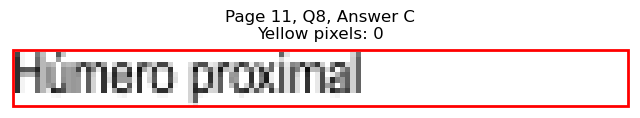

Page 11, Q8 - D: Detected box: x0=327.5, y0=671.7, x1=443.3, y1=682.8
Page 11, Q8, D: Yellow pixels: 0
Page 11, Q8, D: Total non-white pixels: 586
Page 11, Q8, D: Yellow percentage: 0.0%


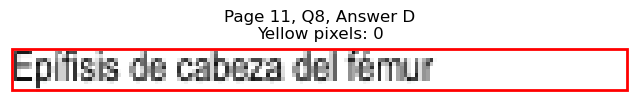


Page 11, Q8 - Selected Answer: A (based on yellow pixel count)




Page 11, Q9 - A: Detected box: x0=68.3, y0=709.6, x1=99.4, y1=720.7
Page 11, Q9, A: Yellow pixels: 0
Page 11, Q9, A: Total non-white pixels: 124
Page 11, Q9, A: Yellow percentage: 0.0%


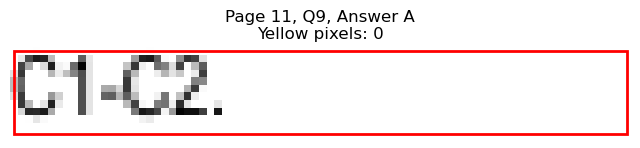

Page 11, Q9 - B: Detected box: x0=68.3, y0=722.2, x1=99.4, y1=733.3
Page 11, Q9, B: Yellow pixels: 0
Page 11, Q9, B: Total non-white pixels: 130
Page 11, Q9, B: Yellow percentage: 0.0%


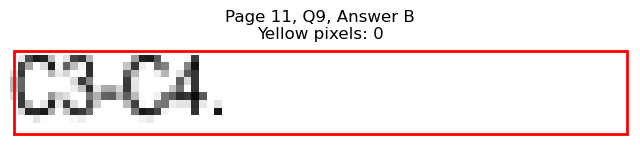

Page 11, Q9 - C: Detected box: x0=327.5, y0=709.6, x1=358.6, y1=720.7
Page 11, Q9, C: Yellow pixels: 884
Page 11, Q9, C: Total non-white pixels: 984
Page 11, Q9, C: Yellow percentage: 89.8%


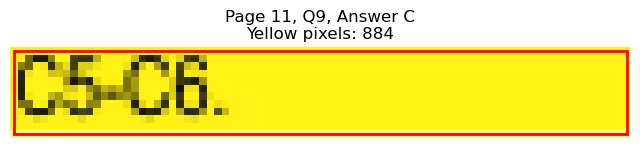

Page 11, Q9 - D: Detected box: x0=327.5, y0=722.2, x1=358.6, y1=733.3
Page 11, Q9, D: Yellow pixels: 0
Page 11, Q9, D: Total non-white pixels: 115
Page 11, Q9, D: Yellow percentage: 0.0%


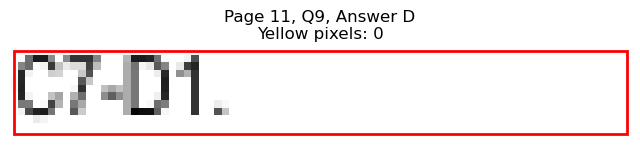


Page 11, Q9 - Selected Answer: C (based on yellow pixel count)





Page 12: Found 1 questions
Page 12, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=78.4, y1=114.8
Page 12, Q1, A: Yellow pixels: 700
Page 12, Q1, A: Total non-white pixels: 732
Page 12, Q1, A: Yellow percentage: 95.6%


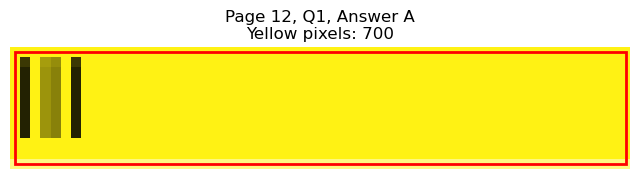

Page 12, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=79.3, y1=127.4
Page 12, Q1, B: Yellow pixels: 0
Page 12, Q1, B: Total non-white pixels: 36
Page 12, Q1, B: Yellow percentage: 0.0%


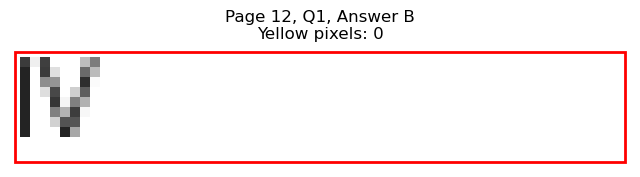

Page 12, Q1 - C: Detected box: x0=315.4, y0=103.8, x1=324.4, y1=114.8
Page 12, Q1, C: Yellow pixels: 0
Page 12, Q1, C: Total non-white pixels: 70
Page 12, Q1, C: Yellow percentage: 0.0%


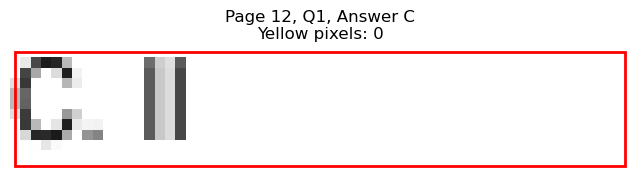

Page 12, Q1 - D: Detected box: x0=315.4, y0=116.4, x1=324.4, y1=127.4
Page 12, Q1, D: Yellow pixels: 0
Page 12, Q1, D: Total non-white pixels: 58
Page 12, Q1, D: Yellow percentage: 0.0%


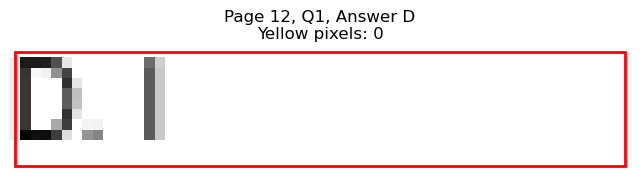


Page 12, Q1 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Neonato de 12 días, recibe LME, traído a urgen...
1   Según la norma técnica peruana para el manejo ...
2   Varón de 9 años con dolor testicular izquierdo...
3   Niño de 3 años, fue traído al centro de salud,...
4   Adolescente de 13 años, es traída a emergencia...
..                                                ...
95  Niño de 5 años, referido de centro periférico ...
96  Recién nacido a término, apgar 9-10. Anteceden...
97  ¿Cuál es la fractura indicativa de maltrato in...
98  En la Rx de columna cervical, la impactación d...
99  En recién nacidos prematuros, según los hallaz...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                     Ictericia por lactancia materna   
1               continuar el tratamiento por 6 meses.   
2                        Ecografía doppler testicular   
3                                         Ceftriaxona   
4                                            Atropina   
..                                                ...   
95                                         Septicemia   
96  Vacuna contra hepatitis B + Inmunoglobulina an...   
97                    Cara posterior de las costillas   
98                                             C1-C2.   
99                                                III   

                                             option_B  \
0                                 Deficiencia de G6PD   
1   iniciar un nuevo esquema, previa evaluación de...   
2                                Ecografía testicular   
3                                         Amoxicilina   
4                                          Flumazenil   
..                                                ...   
95                                       Cetoacidosis   
96  Vacuna contra hepatitis B + Inmunoglobulina an...   
97                                  Placa epifisiaria   
98                                             C3-C4.   
99                                                 IV   

                                        option_C  \
0                           Incompatibilidad ABO   
1   continuar el tratamiento hasta los dos años.   
2                           Resonancia magnética   
3                                 Claritromicina   
4                                       Naloxona   
..                                           ...   
95                                 Shock séptico   
96         No vacunar y esperar serología del RN   
97                               Húmero proximal   
98                                        C5-C6.   
99                                            II   

                                             option_D  
0                                     Sepsis neonatal  
1   reiniciar la indicación hasta completar el esq...  
2                              Gammagrafía testicular  
3                       Amoxicilina-ácido clavulánico  
4                                     Carbón activado  
..                                                ...  
95                               Crisis adrenal aguda  
96                  Solicitar carga viral de la madre  
97                       Epífisis de cabeza del fémur  
98                                             C7-D1.  
99                                                  I  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               A
1               B
2               A
3               D
4               A
..            ...
95              D
96              B
97              A
98              C
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   Neonato de 12 días, recibe LME, traído a urgen...   
1   Según la norma técnica peruana para el manejo ...   
2   Varón de 9 años con dolor testicular izquierdo...   
3   Niño de 3 años, fue traído al centro de salud,...   
4   Adolescente de 13 años, es traída a emergencia...   
..                                                ...   
95  Niño de 5 años, referido de centro periférico ...   
96  Recién nacido a término, apgar 9-10. Anteceden...   
97  ¿Cuál es la fractura indicativa de maltrato in...   
98  En la Rx de columna cervical, la impactación d...   
99  En recién nacidos prematuros, según los hallaz...   

                                             option_A  \
0                     Ictericia por lactancia materna   
1               continuar el tratamiento por 6 meses.   
2                        Ecografía doppler testicular   
3                                         Ceftriaxona   
4                                            Atropina   
..                                                ...   
95                                         Septicemia   
96  Vacuna contra hepatitis B + Inmunoglobulina an...   
97                    Cara posterior de las costillas   
98                                             C1-C2.   
99                                                III   

                                             option_B  \
0                                 Deficiencia de G6PD   
1   iniciar un nuevo esquema, previa evaluación de...   
2                                Ecografía testicular   
3                                         Amoxicilina   
4                                          Flumazenil   
..                                                ...   
95                                       Cetoacidosis   
96  Vacuna contra hepatitis B + Inmunoglobulina an...   
97                                  Placa epifisiaria   
98                                             C3-C4.   
99                                                 IV   

                                        option_C  \
0                           Incompatibilidad ABO   
1   continuar el tratamiento hasta los dos años.   
2                           Resonancia magnética   
3                                 Claritromicina   
4                                       Naloxona   
..                                           ...   
95                                 Shock séptico   
96         No vacunar y esperar serología del RN   
97                               Húmero proximal   
98                                        C5-C6.   
99                                            II   

                                             option_D correct_answer  
0                                     Sepsis neonatal              A  
1   reiniciar la indicación hasta completar el esq...              B  
2                              Gammagrafía testicular              A  
3                       Amoxicilina-ácido clavulánico              D  
4                                     Carbón activado              A  
..                                                ...            ...  
95                               Crisis adrenal aguda              D  
96                  Solicitar carga viral de la madre              B  
97                       Epífisis de cabeza del fémur              A  
98                                             C7-D1.              C  
99                                                  I              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Documents/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2025/PEDIATRIA.csv
